## Regression Analysis_State-wise_MO

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


## Feature Engineering

In [3]:
data= pd.read_csv('Regression_new.csv')
corr= data.corr()

In [4]:
data

,Year,Month,AK,AL,AR,AZ,CA,CO,CT,DE,...,area,population,solar-generation,Spring,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
0,2014,1,1,0,0,0,0,0,0,0,...,664988,736283,0,0,0,0,1,230.0,122,250
1,2014,1,0,1,0,0,0,0,0,0,...,52420,4841799,0,0,0,0,1,3786.0,2778,1999
2,2014,1,0,0,1,0,0,0,0,0,...,53178,2967392,0,0,0,0,1,2002.0,1303,950
3,2014,1,0,0,0,1,0,0,0,0,...,113990,6730413,34,0,0,0,1,2300.0,1149,2101
4,2014,1,0,0,0,0,1,0,0,0,...,163694,38596972,75,0,0,0,1,7773.0,3764,9426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2019,12,0,0,0,0,0,0,0,0,...,9616,623651,3,0,0,0,1,203.0,120,162
3596,2019,12,0,0,0,0,0,0,0,0,...,71298,7698332,1,0,0,0,1,3871.0,1979,2611
3597,2019,12,0,0,0,0,0,0,0,0,...,65496,5836210,2,0,0,0,1,2029.0,1859,1954
3598,2019,12,0,0,0,0,0,0,0,0,...,24230,1781015,0,0,0,0,1,1174.0,1176,596


In [5]:
features=['Residential_Retail Price', 'Industrial_Retail Price', 'Commercial_Retail Price','CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Usage', \
          'Industrial_Usage', 'Commercial_Usage']
#Spring is the seasonal feature baseline
data_MO=data[data.MO==1]
data_MO=data_MO[features]
data_MO

,Residential_Retail Price,Industrial_Retail Price,Commercial_Retail Price,CLDD,TAVG,AWND,HTDD,area,population,solar-generation,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
23,8.92,5.84,7.74,0.000000,25.393750,10.964706,1200.807143,69702,6056202,2,0,0,1,4136.0,1405,2681
73,9.08,6.04,7.93,0.000000,25.770946,8.800000,1081.209459,69702,6057496,3,0,0,1,3694.0,1343,2475
123,9.85,5.68,8.09,0.000000,39.218243,10.482353,785.601351,69702,6058790,4,0,0,0,3024.0,1426,2432
173,10.63,5.56,8.29,10.979730,54.738255,9.642105,312.655405,69702,6060085,5,0,0,0,2120.0,1425,2238
223,11.95,6.29,9.42,138.753333,65.362000,8.021053,127.960000,69702,6061379,6,0,0,0,2300.0,1509,2512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3373,12.71,7.63,10.29,322.943262,75.578723,5.540000,0.319149,69702,6146648,15,1,0,0,3511.0,1046,2948
3423,11.15,7.05,9.19,297.087591,74.935252,6.470000,1.875912,69702,6147965,13,0,1,0,3148.0,1000,2770
3473,10.30,6.01,8.10,35.781690,53.953147,8.029412,370.436620,69702,6149282,11,0,1,0,2386.0,937,2434
3523,9.79,6.06,8.09,0.000000,40.046324,8.158824,724.030075,69702,6150599,9,0,1,0,2619.0,859,2284


In [6]:
def cal_vif(df, feature_columns):
    features= df[feature_columns]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [7]:
commercial_numeric_columns=['Commercial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
residential_numeric_columns=['Residential_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']
industrial_numeric_columns=['Industrial_Retail Price', 'CLDD', 'TAVG', 'AWND', 'HTDD', 'area', 'population', 'solar-generation']

In [8]:
cal_vif(data_MO, commercial_numeric_columns)

Commercial_Retail Price         6.678167
CLDD                           42.688881
TAVG                          490.770613
AWND                            3.362815
HTDD                          304.817924
area                       149925.510047
population                      3.618034
solar-generation                7.161409
dtype: float64

In [9]:
cal_vif(data_MO, residential_numeric_columns)

Residential_Retail Price         7.645370
CLDD                            40.579353
TAVG                           493.584791
AWND                             3.360685
HTDD                           304.826627
area                        149464.082471
population                       3.615929
solar-generation                 7.198433
dtype: float64

In [10]:
cal_vif(data_MO, industrial_numeric_columns)

Industrial_Retail Price         4.630918
CLDD                           43.407788
TAVG                          490.566590
AWND                            3.385964
HTDD                          305.311183
area                       162068.541642
population                      4.078498
solar-generation                7.250089
dtype: float64

Since `TAVG` and `area` goe large VIF, we decided to delete these two columns.

In [11]:
commercial_numeric_columns_adj=['Commercial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_MO, commercial_numeric_columns_adj)

const                      148530.584647
Commercial_Retail Price         6.671957
CLDD                            7.173197
AWND                            3.360848
HTDD                            5.219317
population                      3.564716
solar-generation                7.083281
dtype: float64

In [12]:
industrial_numeric_columns_adj=['Industrial_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_MO, industrial_numeric_columns_adj)

const                      160757.592674
Industrial_Retail Price         4.628536
CLDD                            6.821266
AWND                            3.383331
HTDD                            5.077587
population                      4.020075
solar-generation                7.171363
dtype: float64

In [13]:
residential_numeric_columns_adj=['Residential_Retail Price', 'CLDD','AWND', 'HTDD', 'population', 'solar-generation']
cal_vif(data_MO, residential_numeric_columns_adj)

const                       148246.831736
Residential_Retail Price         7.594712
CLDD                             5.257238
AWND                             3.357788
HTDD                             7.263253
population                       3.559169
solar-generation                 7.110106
dtype: float64

In [14]:
data_MO= data_MO.drop(['TAVG', 'area'],axis = 1)

## Train Test Split and Data Scaling

In [15]:
#Train-Test Split
train, test = train_test_split(data_MO, test_size=0.2)

#splitX,y
def x_y_split(data, y_name, drop_features):
    X = data.drop(drop_features, axis = 1)
    y = data[y_name]
    return X,y

X_train_c, y_train_c = x_y_split(train, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_c,y_test_c = x_y_split(test, 'Commercial_Usage', ['Industrial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_r, y_train_r = x_y_split(train, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_r,y_test_r = x_y_split(test, 'Residential_Usage', ['Industrial_Retail Price', 'Commercial_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

X_train_i, y_train_i = x_y_split(train, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                             'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])
X_test_i,y_test_i = x_y_split(test, 'Industrial_Usage', ['Commercial_Retail Price', 'Residential_Retail Price',\
                                                         'Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'])

In [16]:
train.columns

Index(['Residential_Retail Price', 'Industrial_Retail Price',
       'Commercial_Retail Price', 'CLDD', 'AWND', 'HTDD', 'population',
       'solar-generation', 'Summer', 'Fall', 'Winter', 'Residential_Usage',
       'Industrial_Usage', 'Commercial_Usage'],
      dtype='object')

In [17]:
#categorize X features
categorical_feature_name = ['Summer', 'Fall', 'Winter']

In [18]:
#Scale the data through Robust Scaler

def minmax_scaler(X_train, X_test, numeric_feature_name):
    minMax_Scaler = MinMaxScaler()
    # fit and tranform the training data
    X_train[numeric_feature_name] = minMax_Scaler.fit_transform(X_train[numeric_feature_name]) 
    # tranform test data
    X_test[numeric_feature_name] = minMax_Scaler.transform(X_test[numeric_feature_name]) 
    return (X_train,X_test)

X_train_c, X_test_c = minmax_scaler(X_train_c, X_test_c, commercial_numeric_columns_adj)
X_train_r, X_test_r = minmax_scaler(X_train_r, X_test_r, residential_numeric_columns_adj)
X_train_i, X_test_i = minmax_scaler(X_train_i, X_test_i, industrial_numeric_columns_adj)

### Commercial Consumption Forecast

### Commercial_Linear Regression

In [19]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': predictions})
    
    return df_pred

In [20]:
df_pred_c=sm_regression(X_train_c, y_train_c, X_test_c, y_test_c)

                            OLS Regression Results                            
Dep. Variable:       Commercial_Usage   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     63.46
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           2.88e-23
Time:                        06:04:42   Log-Likelihood:                -317.01
No. Observations:                  57   AIC:                             654.0
Df Residuals:                      47   BIC:                             674.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

In [21]:
df_pred_c

,Actual,Predicted
3523,2284,2441.394098
1823,2508,2482.962758
1573,3046,2976.357238
473,2364,2368.512203
1373,2228,2266.285528
573,2474,2527.745818
1073,2353,2358.089463
1273,2374,2367.069203
1323,2316,2305.082595
3573,2446,2440.255685


In [22]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Performance Evaluation')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [23]:
# Evaluate Performance
evaluate_performances(df_pred_c['Actual'], df_pred_c['Predicted'])

Performance Evaluation
Mean Absolute Error: 51.15392837036516
Mean Squared Error: 4916.971924880438
Root Mean Squared Error: 70.12112324314577


### Commercial_Feature Importance

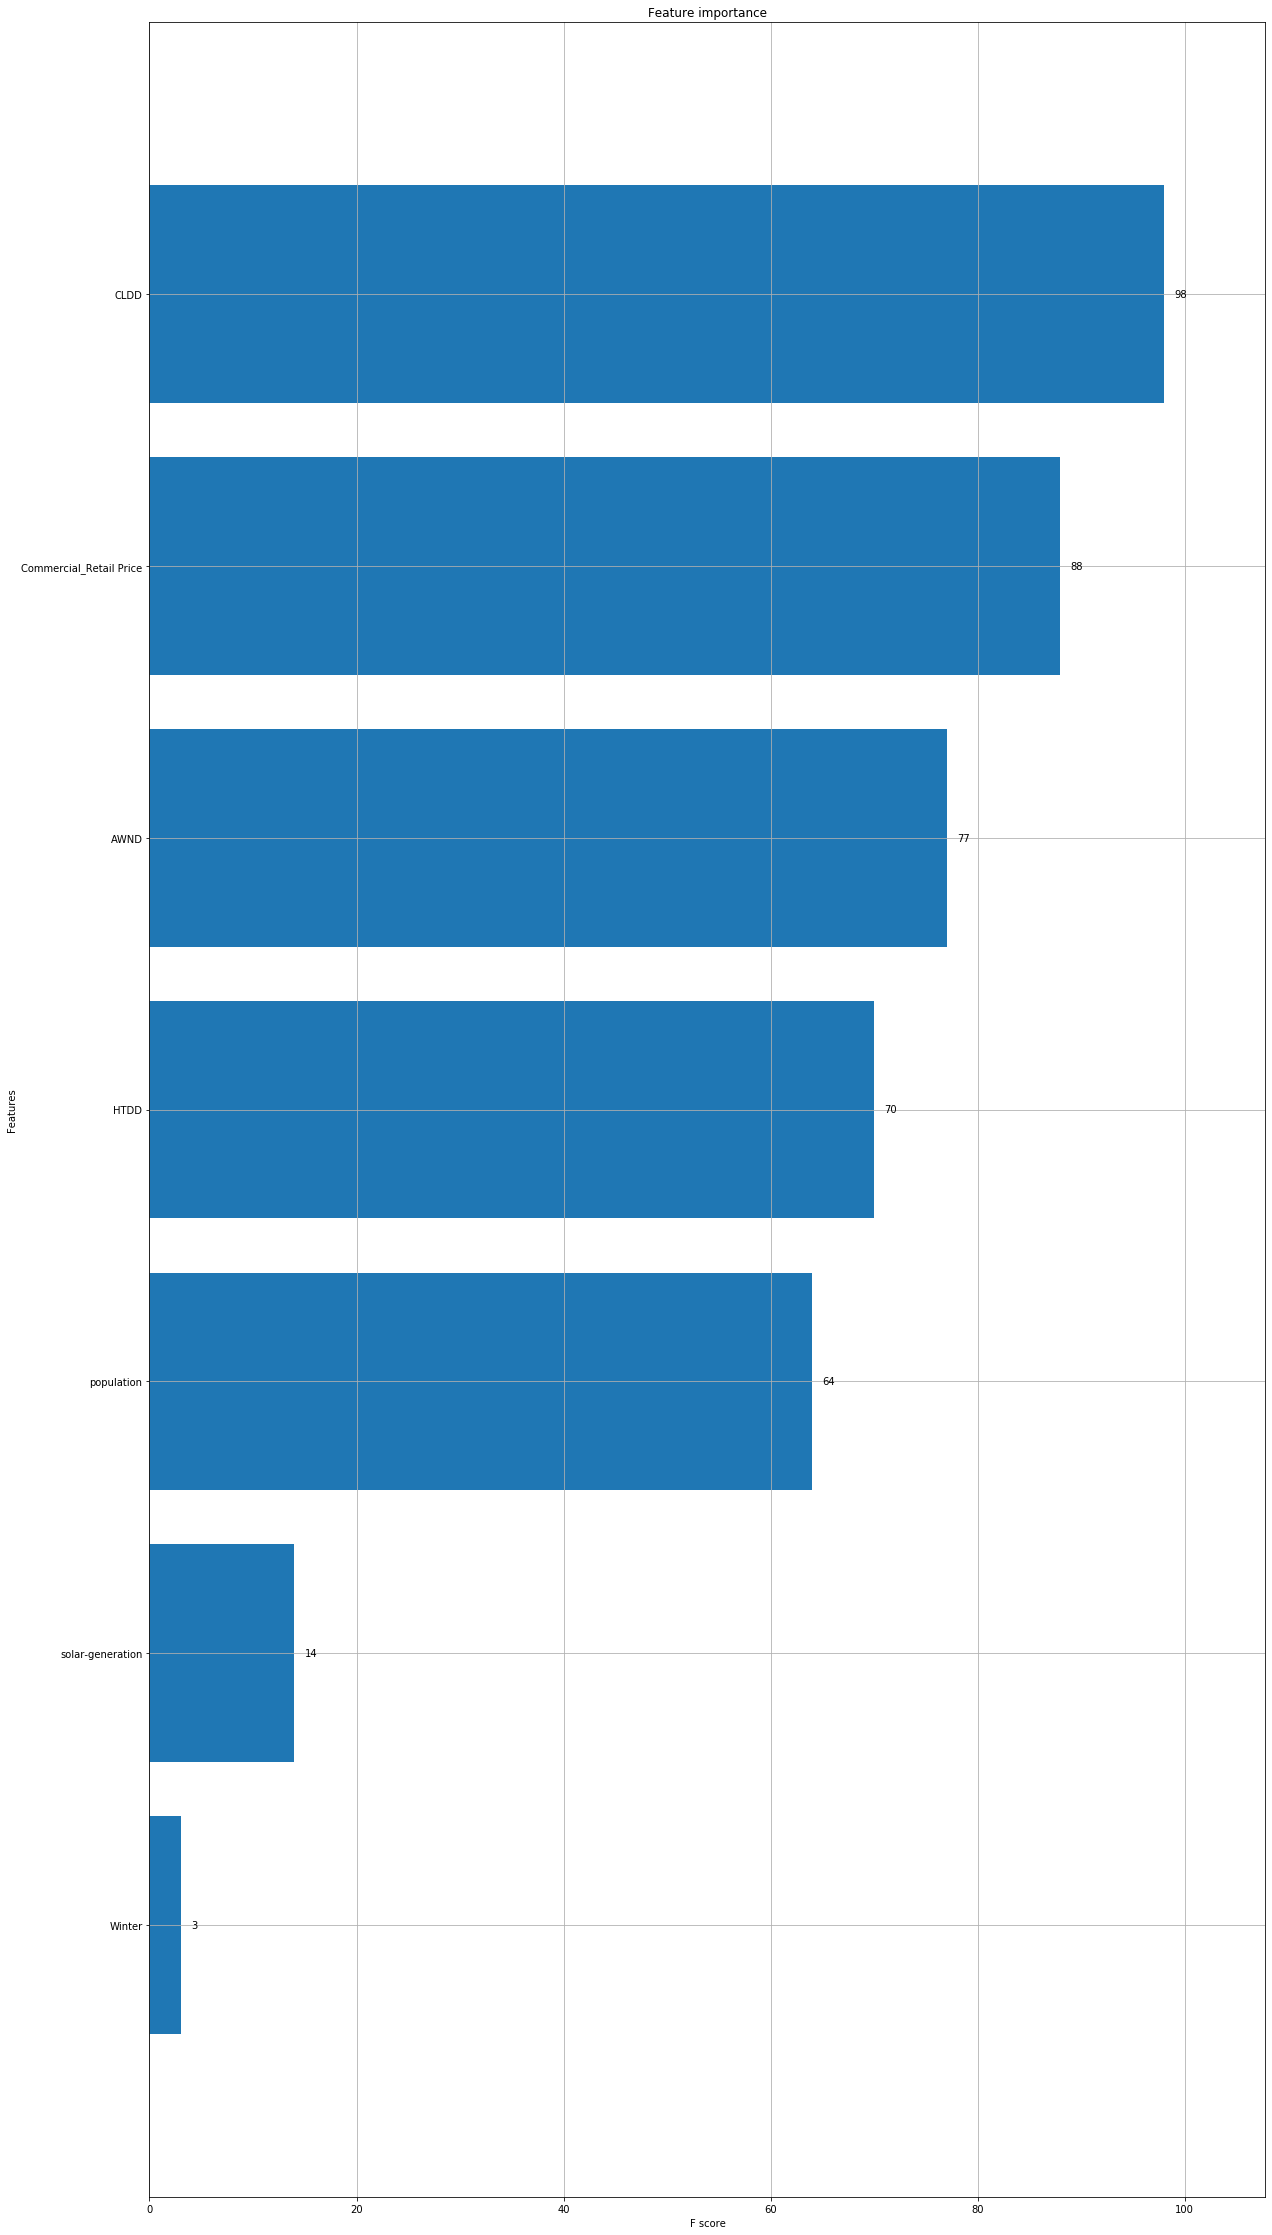

In [24]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_c, y_train_c)

fig, ax = plt.subplots(figsize=(20,40))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

### Commercial_Regression_Visualizations

In [25]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, size=7, aspect=0.8,kind = 'reg')
#     plt.savefig("pairplot.jpg")
    plt.show()

In [26]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in line plot
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",x='Actual', y='Predicted',ax=axes[0])
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2]) 

In [27]:
# Visualization
def visualization(y_test, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


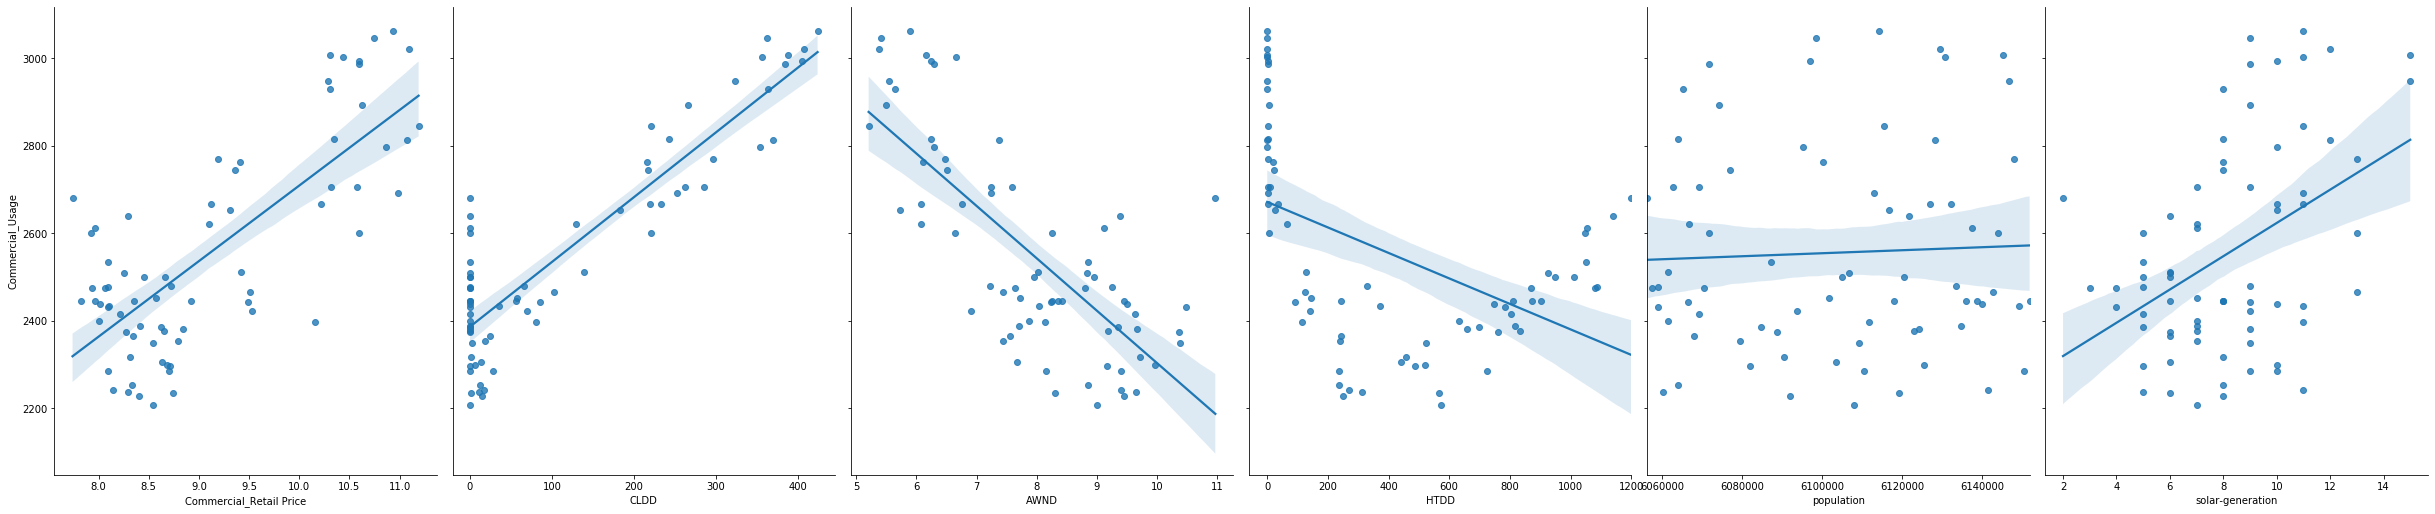

In [28]:
# Correlation Analysis
correlation_analysis(data_MO, commercial_numeric_columns_adj, ['Commercial_Usage'])

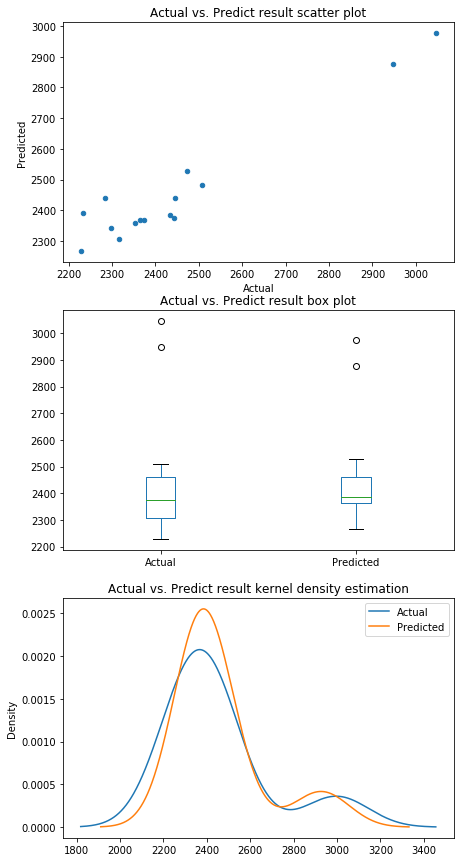

In [29]:
# Visualize Output
visualize_graph(df_pred_c)

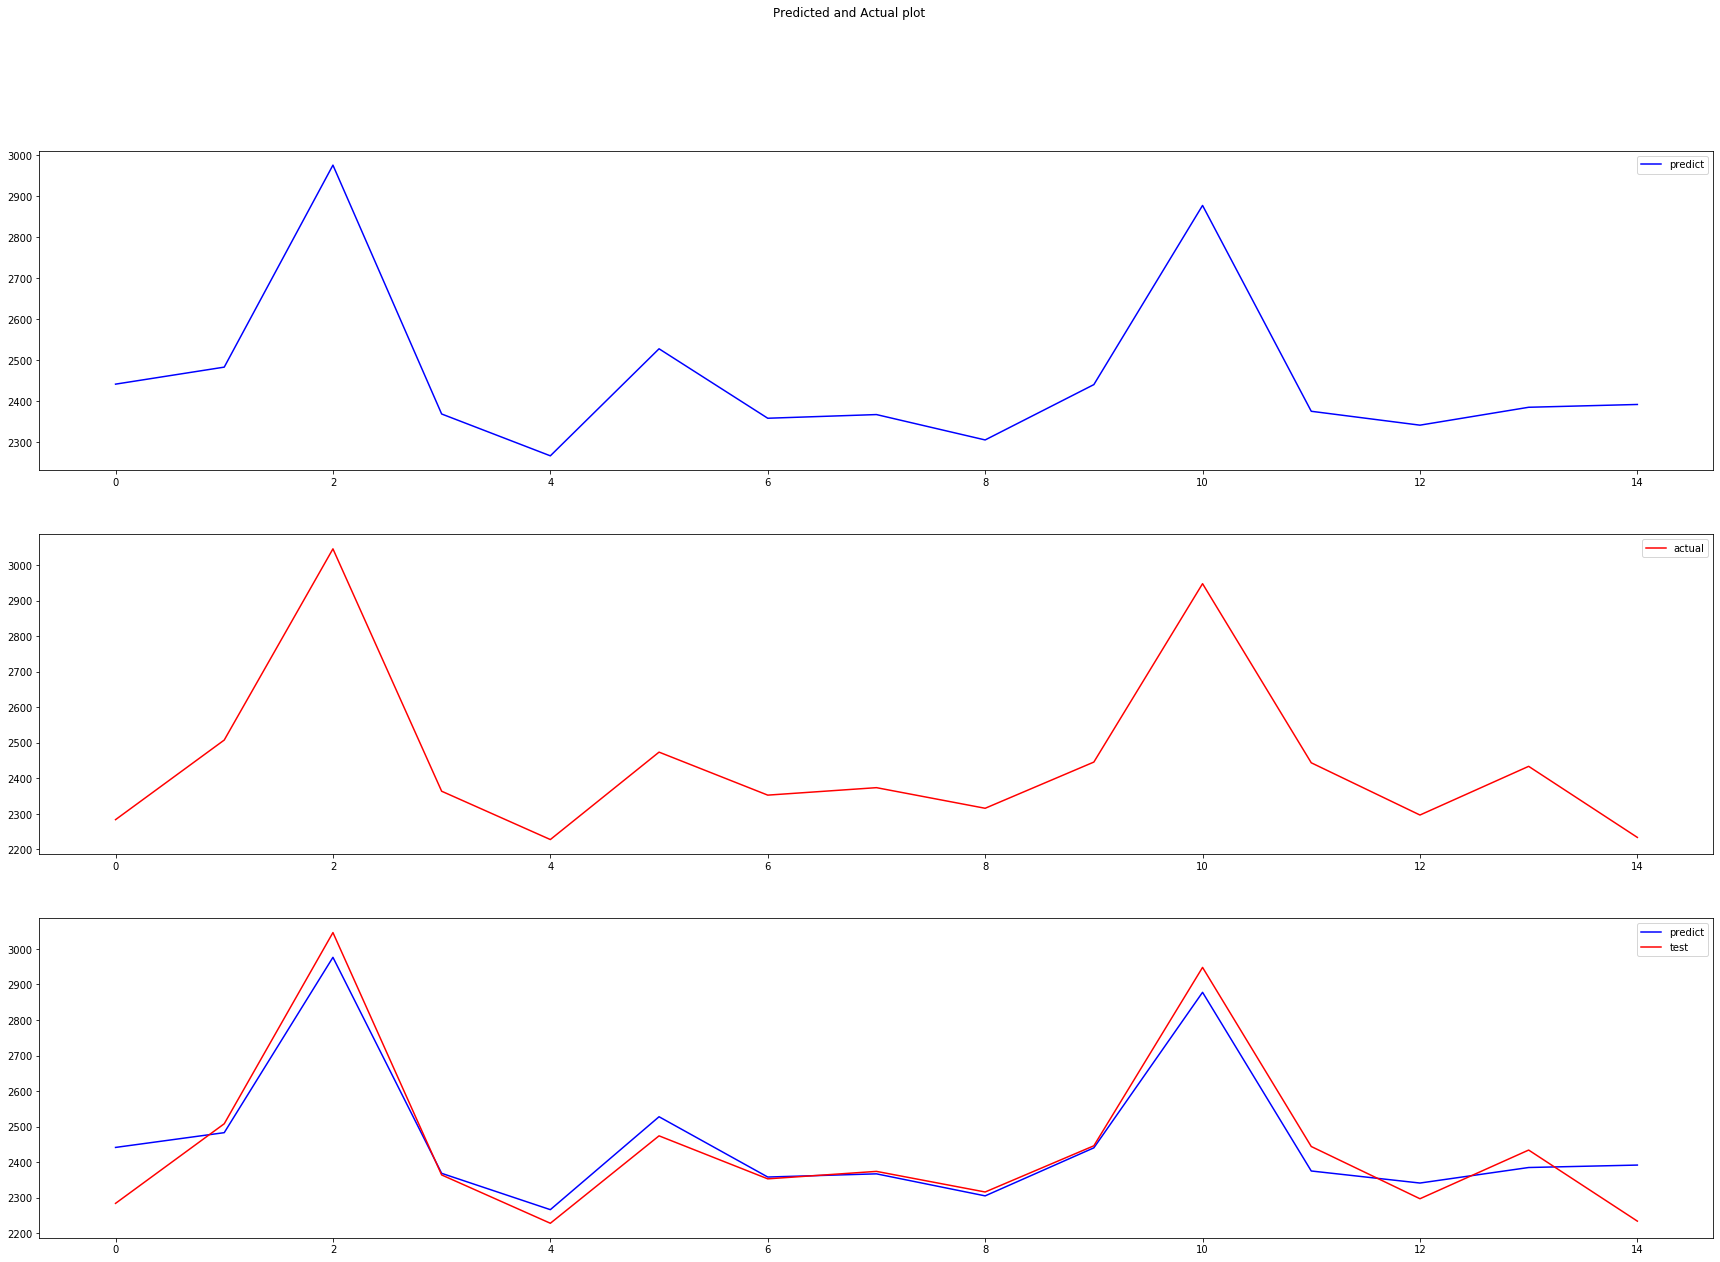

In [30]:
visualization(df_pred_c.Actual, df_pred_c.Predicted)

### Commercial_ANN

In [31]:
features_ANN_c=['Year', 'Month', 'Commercial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Commercial_Retail Price']
#Spring is the seasonal feature baseline
data_MO_ANN=data[data.MO==1]
data_MO_ANN=data_MO_ANN[features_ANN_c]
data_MO_ANN

,Year,Month,Commercial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Commercial_Retail Price
23,2014,1,2681,0.000000,10.964706,1200.807143,6056202,2,0,0,1,7.74
73,2014,2,2475,0.000000,8.800000,1081.209459,6057496,3,0,0,1,7.93
123,2014,3,2432,0.000000,10.482353,785.601351,6058790,4,0,0,0,8.09
173,2014,4,2238,10.979730,9.642105,312.655405,6060085,5,0,0,0,8.29
223,2014,5,2512,138.753333,8.021053,127.960000,6061379,6,0,0,0,9.42
...,...,...,...,...,...,...,...,...,...,...,...,...
3373,2019,8,2948,322.943262,5.540000,0.319149,6146648,15,1,0,0,10.29
3423,2019,9,2770,297.087591,6.470000,1.875912,6147965,13,0,1,0,9.19
3473,2019,10,2434,35.781690,8.029412,370.436620,6149282,11,0,1,0,8.10
3523,2019,11,2284,0.000000,8.158824,724.030075,6150599,9,0,1,0,8.09


In [32]:
train_ANN, test_ANN = train_test_split(data_MO_ANN, test_size=0.2)
X_train_ANN_c, y_train_ANN_c = x_y_split(train_ANN, 'Commercial_Usage', ['Commercial_Usage'])
X_test_ANN_c,y_test_ANN_c = x_y_split(test_ANN, 'Commercial_Usage', ['Commercial_Usage'])

In [33]:
X_train_ANN_c, X_test_ANN_c = minmax_scaler(X_train_ANN_c, X_test_ANN_c, commercial_numeric_columns_adj)
y_train_ANN_c = (y_train_ANN_c - min(y_train_ANN_c))/(max(y_train_ANN_c) - min(y_train_ANN_c))

In [34]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Adding the second hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_c, y_train_ANN_c, validation_split = 0.2, batch_size = 10, epochs = 1200)

Train on 45 samples, validate on 12 samples
Epoch 1/1200
45/45 [==============================] - 1s 24ms/step - loss: 0.1017 - mae: 0.2813 - val_loss: 0.0649 - val_mae: 0.2269
Epoch 2/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0755 - mae: 0.2387 - val_loss: 0.0545 - val_mae: 0.2064
Epoch 3/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0719 - mae: 0.2083 - val_loss: 0.0588 - val_mae: 0.2003
Epoch 4/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0734 - mae: 0.2109 - val_loss: 0.0554 - val_mae: 0.2029
Epoch 5/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0704 - mae: 0.2103 - val_loss: 0.0548 - val_mae: 0.2048
Epoch 6/1200
45/45 [==============================] - 0s 489us/step - loss: 0.0694 - mae: 0.2146 - val_loss: 0.0543 - val_mae: 0.2089
Epoch 7/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0703 - mae: 0.2224 - val_loss: 0.0547 - val_mae: 0.2117
Epoch 8/1200
45/45 

45/45 [==============================] - 0s 488us/step - loss: 0.0693 - mae: 0.2128 - val_loss: 0.0546 - val_mae: 0.2034
Epoch 62/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0698 - mae: 0.2111 - val_loss: 0.0549 - val_mae: 0.2023
Epoch 63/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0699 - mae: 0.2106 - val_loss: 0.0545 - val_mae: 0.2035
Epoch 64/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0697 - mae: 0.2114 - val_loss: 0.0548 - val_mae: 0.2027
Epoch 65/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0701 - mae: 0.2109 - val_loss: 0.0547 - val_mae: 0.2029
Epoch 66/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0694 - mae: 0.2117 - val_loss: 0.0541 - val_mae: 0.2051
Epoch 67/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0699 - mae: 0.2165 - val_loss: 0.0539 - val_mae: 0.2067
Epoch 68/1200
45/45 [==============================] - 0s 487us/step 

45/45 [==============================] - 0s 465us/step - loss: 0.0677 - mae: 0.2109 - val_loss: 0.0536 - val_mae: 0.1988
Epoch 122/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0707 - mae: 0.2076 - val_loss: 0.0557 - val_mae: 0.1981
Epoch 123/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0684 - mae: 0.2054 - val_loss: 0.0536 - val_mae: 0.2021
Epoch 124/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0707 - mae: 0.2195 - val_loss: 0.0533 - val_mae: 0.2084
Epoch 125/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0693 - mae: 0.2212 - val_loss: 0.0533 - val_mae: 0.2088
Epoch 126/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0690 - mae: 0.2201 - val_loss: 0.0530 - val_mae: 0.2059
Epoch 127/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0683 - mae: 0.2151 - val_loss: 0.0532 - val_mae: 0.2034
Epoch 128/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 465us/step - loss: 0.0567 - mae: 0.1866 - val_loss: 0.0433 - val_mae: 0.1855
Epoch 182/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0649 - mae: 0.2149 - val_loss: 0.0434 - val_mae: 0.1808
Epoch 183/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0546 - mae: 0.1819 - val_loss: 0.0583 - val_mae: 0.1946
Epoch 184/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0640 - mae: 0.1944 - val_loss: 0.0425 - val_mae: 0.1839
Epoch 185/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0545 - mae: 0.1947 - val_loss: 0.0437 - val_mae: 0.1786
Epoch 186/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0572 - mae: 0.1952 - val_loss: 0.0434 - val_mae: 0.1780
Epoch 187/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0576 - mae: 0.1868 - val_loss: 0.0451 - val_mae: 0.1806
Epoch 188/1200
45/45 [==============================] - 0s 554u

45/45 [==============================] - 0s 510us/step - loss: 0.0264 - mae: 0.1369 - val_loss: 0.0295 - val_mae: 0.1319
Epoch 242/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0261 - mae: 0.1323 - val_loss: 0.0293 - val_mae: 0.1309
Epoch 243/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0261 - mae: 0.1334 - val_loss: 0.0285 - val_mae: 0.1277
Epoch 244/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0274 - mae: 0.1362 - val_loss: 0.0340 - val_mae: 0.1431
Epoch 245/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0263 - mae: 0.1309 - val_loss: 0.0258 - val_mae: 0.1189
Epoch 246/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0310 - mae: 0.1494 - val_loss: 0.0372 - val_mae: 0.1523
Epoch 247/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0262 - mae: 0.1313 - val_loss: 0.0270 - val_mae: 0.1238
Epoch 248/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 443us/step - loss: 0.0218 - mae: 0.1235 - val_loss: 0.0253 - val_mae: 0.1111
Epoch 302/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0216 - mae: 0.1228 - val_loss: 0.0286 - val_mae: 0.1212
Epoch 303/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0216 - mae: 0.1213 - val_loss: 0.0273 - val_mae: 0.1171
Epoch 304/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0225 - mae: 0.1250 - val_loss: 0.0260 - val_mae: 0.1122
Epoch 305/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0218 - mae: 0.1211 - val_loss: 0.0310 - val_mae: 0.1291
Epoch 306/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0249 - mae: 0.1328 - val_loss: 0.0284 - val_mae: 0.1208
Epoch 307/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0238 - mae: 0.1246 - val_loss: 0.0289 - val_mae: 0.1221
Epoch 308/1200
45/45 [==============================] - 0s 665u

45/45 [==============================] - 0s 665us/step - loss: 0.0219 - mae: 0.1241 - val_loss: 0.0245 - val_mae: 0.1076
Epoch 362/1200
45/45 [==============================] - 0s 643us/step - loss: 0.0200 - mae: 0.1164 - val_loss: 0.0247 - val_mae: 0.1081
Epoch 363/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0198 - mae: 0.1171 - val_loss: 0.0266 - val_mae: 0.1167
Epoch 364/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0202 - mae: 0.1170 - val_loss: 0.0242 - val_mae: 0.1061
Epoch 365/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0230 - mae: 0.1278 - val_loss: 0.0347 - val_mae: 0.1420
Epoch 366/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0237 - mae: 0.1260 - val_loss: 0.0242 - val_mae: 0.1061
Epoch 367/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0199 - mae: 0.1179 - val_loss: 0.0236 - val_mae: 0.1035
Epoch 368/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 465us/step - loss: 0.0230 - mae: 0.1230 - val_loss: 0.0226 - val_mae: 0.1008
Epoch 422/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0258 - mae: 0.1358 - val_loss: 0.0292 - val_mae: 0.1247
Epoch 423/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0216 - mae: 0.1191 - val_loss: 0.0216 - val_mae: 0.0981
Epoch 424/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0203 - mae: 0.1200 - val_loss: 0.0226 - val_mae: 0.1019
Epoch 425/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0190 - mae: 0.1144 - val_loss: 0.0226 - val_mae: 0.1021
Epoch 426/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0212 - mae: 0.1207 - val_loss: 0.0261 - val_mae: 0.1151
Epoch 427/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0203 - mae: 0.1168 - val_loss: 0.0242 - val_mae: 0.1079
Epoch 428/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 443us/step - loss: 0.0189 - mae: 0.1139 - val_loss: 0.0222 - val_mae: 0.1023
Epoch 482/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0186 - mae: 0.1123 - val_loss: 0.0207 - val_mae: 0.0949
Epoch 483/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0190 - mae: 0.1162 - val_loss: 0.0244 - val_mae: 0.1100
Epoch 484/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0202 - mae: 0.1159 - val_loss: 0.0220 - val_mae: 0.1006
Epoch 485/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0203 - mae: 0.1185 - val_loss: 0.0239 - val_mae: 0.1085
Epoch 486/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0183 - mae: 0.1117 - val_loss: 0.0236 - val_mae: 0.1074
Epoch 487/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0187 - mae: 0.1138 - val_loss: 0.0219 - val_mae: 0.1001
Epoch 488/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 576us/step - loss: 0.0202 - mae: 0.1207 - val_loss: 0.0204 - val_mae: 0.0957
Epoch 542/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0194 - mae: 0.1177 - val_loss: 0.0226 - val_mae: 0.1045
Epoch 543/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0197 - mae: 0.1141 - val_loss: 0.0230 - val_mae: 0.1058
Epoch 544/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0176 - mae: 0.1083 - val_loss: 0.0194 - val_mae: 0.0930
Epoch 545/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0182 - mae: 0.1111 - val_loss: 0.0216 - val_mae: 0.1008
Epoch 546/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0172 - mae: 0.1082 - val_loss: 0.0198 - val_mae: 0.0938
Epoch 547/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0181 - mae: 0.1126 - val_loss: 0.0237 - val_mae: 0.1083
Epoch 548/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 443us/step - loss: 0.0203 - mae: 0.1172 - val_loss: 0.0190 - val_mae: 0.0931
Epoch 602/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0180 - mae: 0.1100 - val_loss: 0.0234 - val_mae: 0.1082
Epoch 603/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0157 - mae: 0.1045 - val_loss: 0.0181 - val_mae: 0.0967
Epoch 604/1200
45/45 [==============================] - 0s 422us/step - loss: 0.0180 - mae: 0.1114 - val_loss: 0.0248 - val_mae: 0.1122
Epoch 605/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0168 - mae: 0.1078 - val_loss: 0.0183 - val_mae: 0.0936
Epoch 606/1200
45/45 [==============================] - 0s 511us/step - loss: 0.0188 - mae: 0.1119 - val_loss: 0.0210 - val_mae: 0.0986
Epoch 607/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0191 - mae: 0.1170 - val_loss: 0.0253 - val_mae: 0.1142
Epoch 608/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 488us/step - loss: 0.0158 - mae: 0.1031 - val_loss: 0.0203 - val_mae: 0.0959
Epoch 662/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0158 - mae: 0.1041 - val_loss: 0.0198 - val_mae: 0.0943
Epoch 663/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0156 - mae: 0.1035 - val_loss: 0.0183 - val_mae: 0.0918
Epoch 664/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0164 - mae: 0.1049 - val_loss: 0.0202 - val_mae: 0.0969
Epoch 665/1200
45/45 [==============================] - 0s 444us/step - loss: 0.0162 - mae: 0.1043 - val_loss: 0.0211 - val_mae: 0.1006
Epoch 666/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0167 - mae: 0.1092 - val_loss: 0.0188 - val_mae: 0.0923
Epoch 667/1200
45/45 [==============================] - 0s 444us/step - loss: 0.0178 - mae: 0.1121 - val_loss: 0.0179 - val_mae: 0.0917
Epoch 668/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 554us/step - loss: 0.0171 - mae: 0.1095 - val_loss: 0.0167 - val_mae: 0.0946
Epoch 722/1200
45/45 [==============================] - 0s 621us/step - loss: 0.0172 - mae: 0.1073 - val_loss: 0.0218 - val_mae: 0.1051
Epoch 723/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0177 - mae: 0.1087 - val_loss: 0.0170 - val_mae: 0.0902
Epoch 724/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0178 - mae: 0.1111 - val_loss: 0.0169 - val_mae: 0.0902
Epoch 725/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0156 - mae: 0.1020 - val_loss: 0.0207 - val_mae: 0.1015
Epoch 726/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0158 - mae: 0.1037 - val_loss: 0.0169 - val_mae: 0.0903
Epoch 727/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0163 - mae: 0.1056 - val_loss: 0.0196 - val_mae: 0.0972
Epoch 728/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 488us/step - loss: 0.0155 - mae: 0.1024 - val_loss: 0.0171 - val_mae: 0.0880
Epoch 782/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0161 - mae: 0.1060 - val_loss: 0.0174 - val_mae: 0.0889
Epoch 783/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0152 - mae: 0.1020 - val_loss: 0.0166 - val_mae: 0.0882
Epoch 784/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0150 - mae: 0.1008 - val_loss: 0.0186 - val_mae: 0.0937
Epoch 785/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0149 - mae: 0.1026 - val_loss: 0.0164 - val_mae: 0.0887
Epoch 786/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0160 - mae: 0.1013 - val_loss: 0.0218 - val_mae: 0.1043
Epoch 787/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0171 - mae: 0.1052 - val_loss: 0.0170 - val_mae: 0.0892
Epoch 788/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 443us/step - loss: 0.0142 - mae: 0.0977 - val_loss: 0.0250 - val_mae: 0.1181
Epoch 842/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0167 - mae: 0.1045 - val_loss: 0.0159 - val_mae: 0.0887
Epoch 843/1200
45/45 [==============================] - 0s 511us/step - loss: 0.0158 - mae: 0.1012 - val_loss: 0.0199 - val_mae: 0.1001
Epoch 844/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0149 - mae: 0.1015 - val_loss: 0.0159 - val_mae: 0.0886
Epoch 845/1200
45/45 [==============================] - 0s 489us/step - loss: 0.0160 - mae: 0.1029 - val_loss: 0.0179 - val_mae: 0.0918
Epoch 846/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0150 - mae: 0.1034 - val_loss: 0.0160 - val_mae: 0.0874
Epoch 847/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0146 - mae: 0.0985 - val_loss: 0.0175 - val_mae: 0.0902
Epoch 848/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 465us/step - loss: 0.0138 - mae: 0.0980 - val_loss: 0.0158 - val_mae: 0.0866
Epoch 902/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0146 - mae: 0.0984 - val_loss: 0.0195 - val_mae: 0.0976
Epoch 903/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0163 - mae: 0.1093 - val_loss: 0.0161 - val_mae: 0.0868
Epoch 904/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0142 - mae: 0.0990 - val_loss: 0.0195 - val_mae: 0.0972
Epoch 905/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0144 - mae: 0.0980 - val_loss: 0.0159 - val_mae: 0.0864
Epoch 906/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0142 - mae: 0.0977 - val_loss: 0.0196 - val_mae: 0.0976
Epoch 907/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0160 - mae: 0.1042 - val_loss: 0.0160 - val_mae: 0.0864
Epoch 908/1200
45/45 [==============================] - 0s 466u

45/45 [==============================] - 0s 443us/step - loss: 0.0148 - mae: 0.1014 - val_loss: 0.0159 - val_mae: 0.0853
Epoch 962/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0144 - mae: 0.0998 - val_loss: 0.0157 - val_mae: 0.0851
Epoch 963/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0142 - mae: 0.0970 - val_loss: 0.0177 - val_mae: 0.0909
Epoch 964/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0145 - mae: 0.1011 - val_loss: 0.0154 - val_mae: 0.0843
Epoch 965/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0138 - mae: 0.0971 - val_loss: 0.0160 - val_mae: 0.0855
Epoch 966/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0149 - mae: 0.0992 - val_loss: 0.0178 - val_mae: 0.0917
Epoch 967/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0160 - mae: 0.1024 - val_loss: 0.0171 - val_mae: 0.0887
Epoch 968/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 598us/step - loss: 0.0167 - mae: 0.1096 - val_loss: 0.0152 - val_mae: 0.0838
Epoch 1022/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0153 - mae: 0.1007 - val_loss: 0.0160 - val_mae: 0.0852
Epoch 1023/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0136 - mae: 0.0968 - val_loss: 0.0150 - val_mae: 0.0836
Epoch 1024/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0145 - mae: 0.0998 - val_loss: 0.0163 - val_mae: 0.0860
Epoch 1025/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0135 - mae: 0.0958 - val_loss: 0.0150 - val_mae: 0.0840
Epoch 1026/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0136 - mae: 0.0945 - val_loss: 0.0179 - val_mae: 0.0922
Epoch 1027/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0153 - mae: 0.1025 - val_loss: 0.0152 - val_mae: 0.0841
Epoch 1028/1200
45/45 [==============================] - 

Epoch 1081/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0129 - mae: 0.0950 - val_loss: 0.0147 - val_mae: 0.0835
Epoch 1082/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0137 - mae: 0.0947 - val_loss: 0.0161 - val_mae: 0.0860
Epoch 1083/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0125 - mae: 0.0918 - val_loss: 0.0146 - val_mae: 0.0833
Epoch 1084/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0129 - mae: 0.0929 - val_loss: 0.0161 - val_mae: 0.0864
Epoch 1085/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0127 - mae: 0.0936 - val_loss: 0.0149 - val_mae: 0.0838
Epoch 1086/1200
45/45 [==============================] - 0s 444us/step - loss: 0.0132 - mae: 0.0931 - val_loss: 0.0153 - val_mae: 0.0837
Epoch 1087/1200
45/45 [==============================] - 0s 444us/step - loss: 0.0122 - mae: 0.0908 - val_loss: 0.0151 - val_mae: 0.0836
Epoch 1088/1200
45/45 [==================

Epoch 1141/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0119 - mae: 0.0886 - val_loss: 0.0151 - val_mae: 0.0840
Epoch 1142/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0129 - mae: 0.0945 - val_loss: 0.0142 - val_mae: 0.0814
Epoch 1143/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0118 - mae: 0.0879 - val_loss: 0.0140 - val_mae: 0.0813
Epoch 1144/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0121 - mae: 0.0908 - val_loss: 0.0155 - val_mae: 0.0847
Epoch 1145/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0120 - mae: 0.0905 - val_loss: 0.0140 - val_mae: 0.0814
Epoch 1146/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0121 - mae: 0.0894 - val_loss: 0.0143 - val_mae: 0.0814
Epoch 1147/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0118 - mae: 0.0899 - val_loss: 0.0140 - val_mae: 0.0813
Epoch 1148/1200
45/45 [==================

In [35]:
# Predicting the Test set results
predictions_ANN_c = classifier.predict(X_test_ANN_c)
# Scale y back 
predictions_ANN_c = (predictions_ANN_c * (max(y_test_ANN_c) - min(y_test_ANN_c))) + min(y_test_ANN_c)
predictions_ANN_c = predictions_ANN_c.reshape(-1)
df_pred_ANN_c = pd.DataFrame({'Actual': y_test_ANN_c, 'Predicted': predictions_ANN_c})

In [36]:
df_pred_ANN_c

,Actual,Predicted
1173,2385,2484.039307
373,2930,2898.416016
2423,2639,2434.381592
823,2443,2441.263916
573,2474,2539.562988
2723,3021,2922.324219
3123,2437,2369.942139
3323,3007,2877.928955
1373,2228,2387.466064
3373,2948,2871.330566


In [37]:
evaluate_performances(y_test_ANN_c, predictions_ANN_c)

Performance Evaluation
Mean Absolute Error: 80.803173828125
Mean Squared Error: 9229.71608881553
Root Mean Squared Error: 96.07141140222481


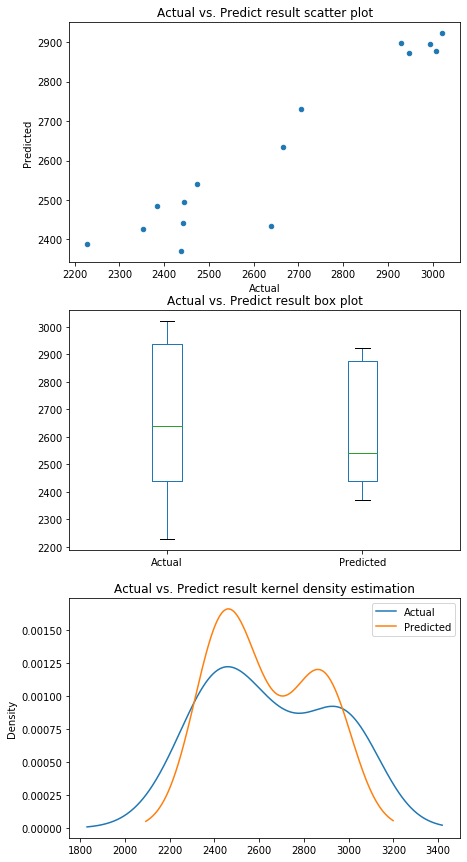

In [38]:
visualize_graph(df_pred_ANN_c)

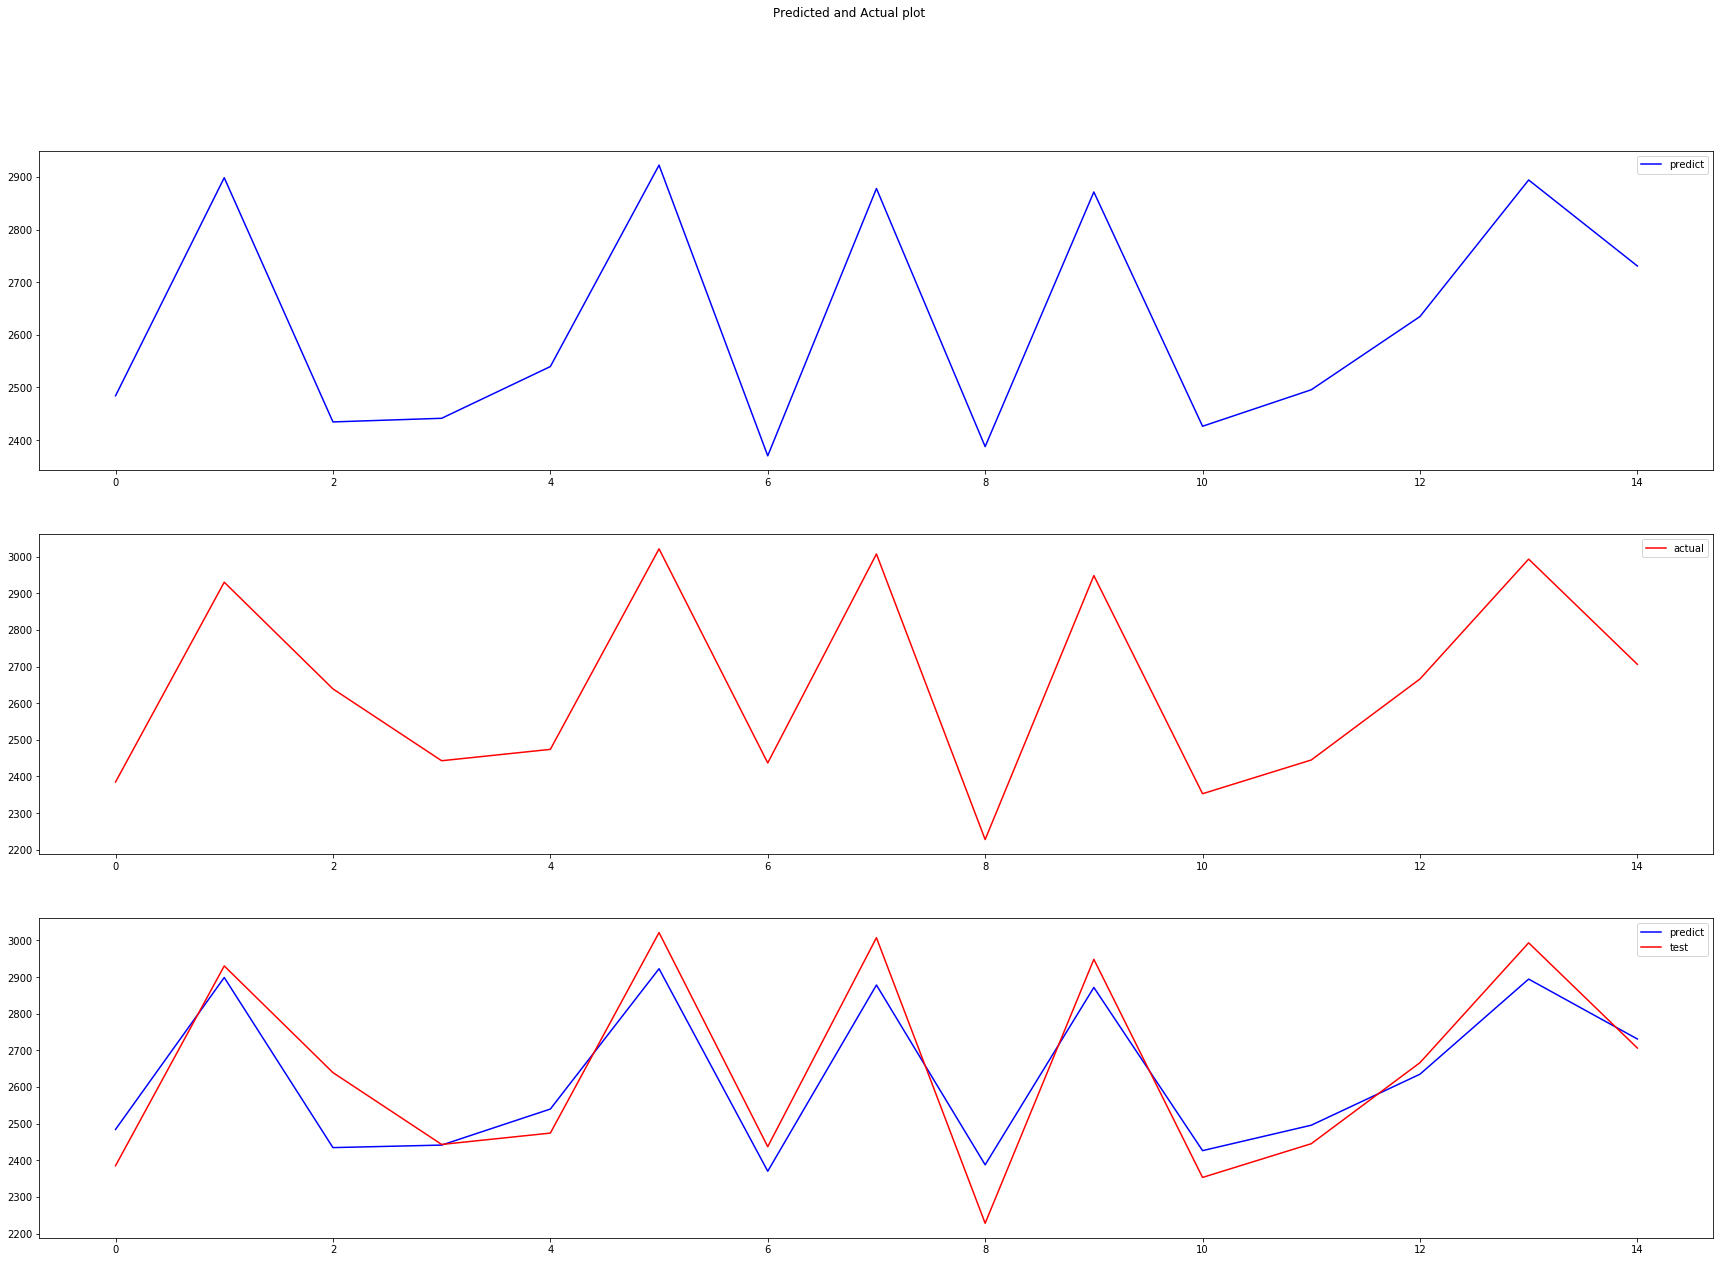

In [39]:
visualization(df_pred_ANN_c.Actual, df_pred_ANN_c.Predicted)

## Industrial Consumption Forecast

In [40]:
df_pred_i=sm_regression(X_train_i, y_train_i, X_test_i, y_test_i)

                            OLS Regression Results                            
Dep. Variable:       Industrial_Usage   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     47.48
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           1.34e-20
Time:                        06:05:32   Log-Likelihood:                -314.61
No. Observations:                  57   AIC:                             649.2
Df Residuals:                      47   BIC:                             669.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

In [41]:
df_pred_i

,Actual,Predicted
3523,859,963.664532
1823,1048,1078.418120
1573,1206,1334.577098
473,1472,1429.144018
1373,1042,1207.973746
573,1392,1384.225630
1073,1439,1339.586122
1273,1130,1150.271799
1323,1084,1215.442493
3573,862,908.610802


In [42]:
evaluate_performances(df_pred_i['Actual'], df_pred_i['Predicted'])

Performance Evaluation
Mean Absolute Error: 60.268665765678975
Mean Squared Error: 6100.279829129577
Root Mean Squared Error: 78.10428816095552


# Industrial Feature Importance

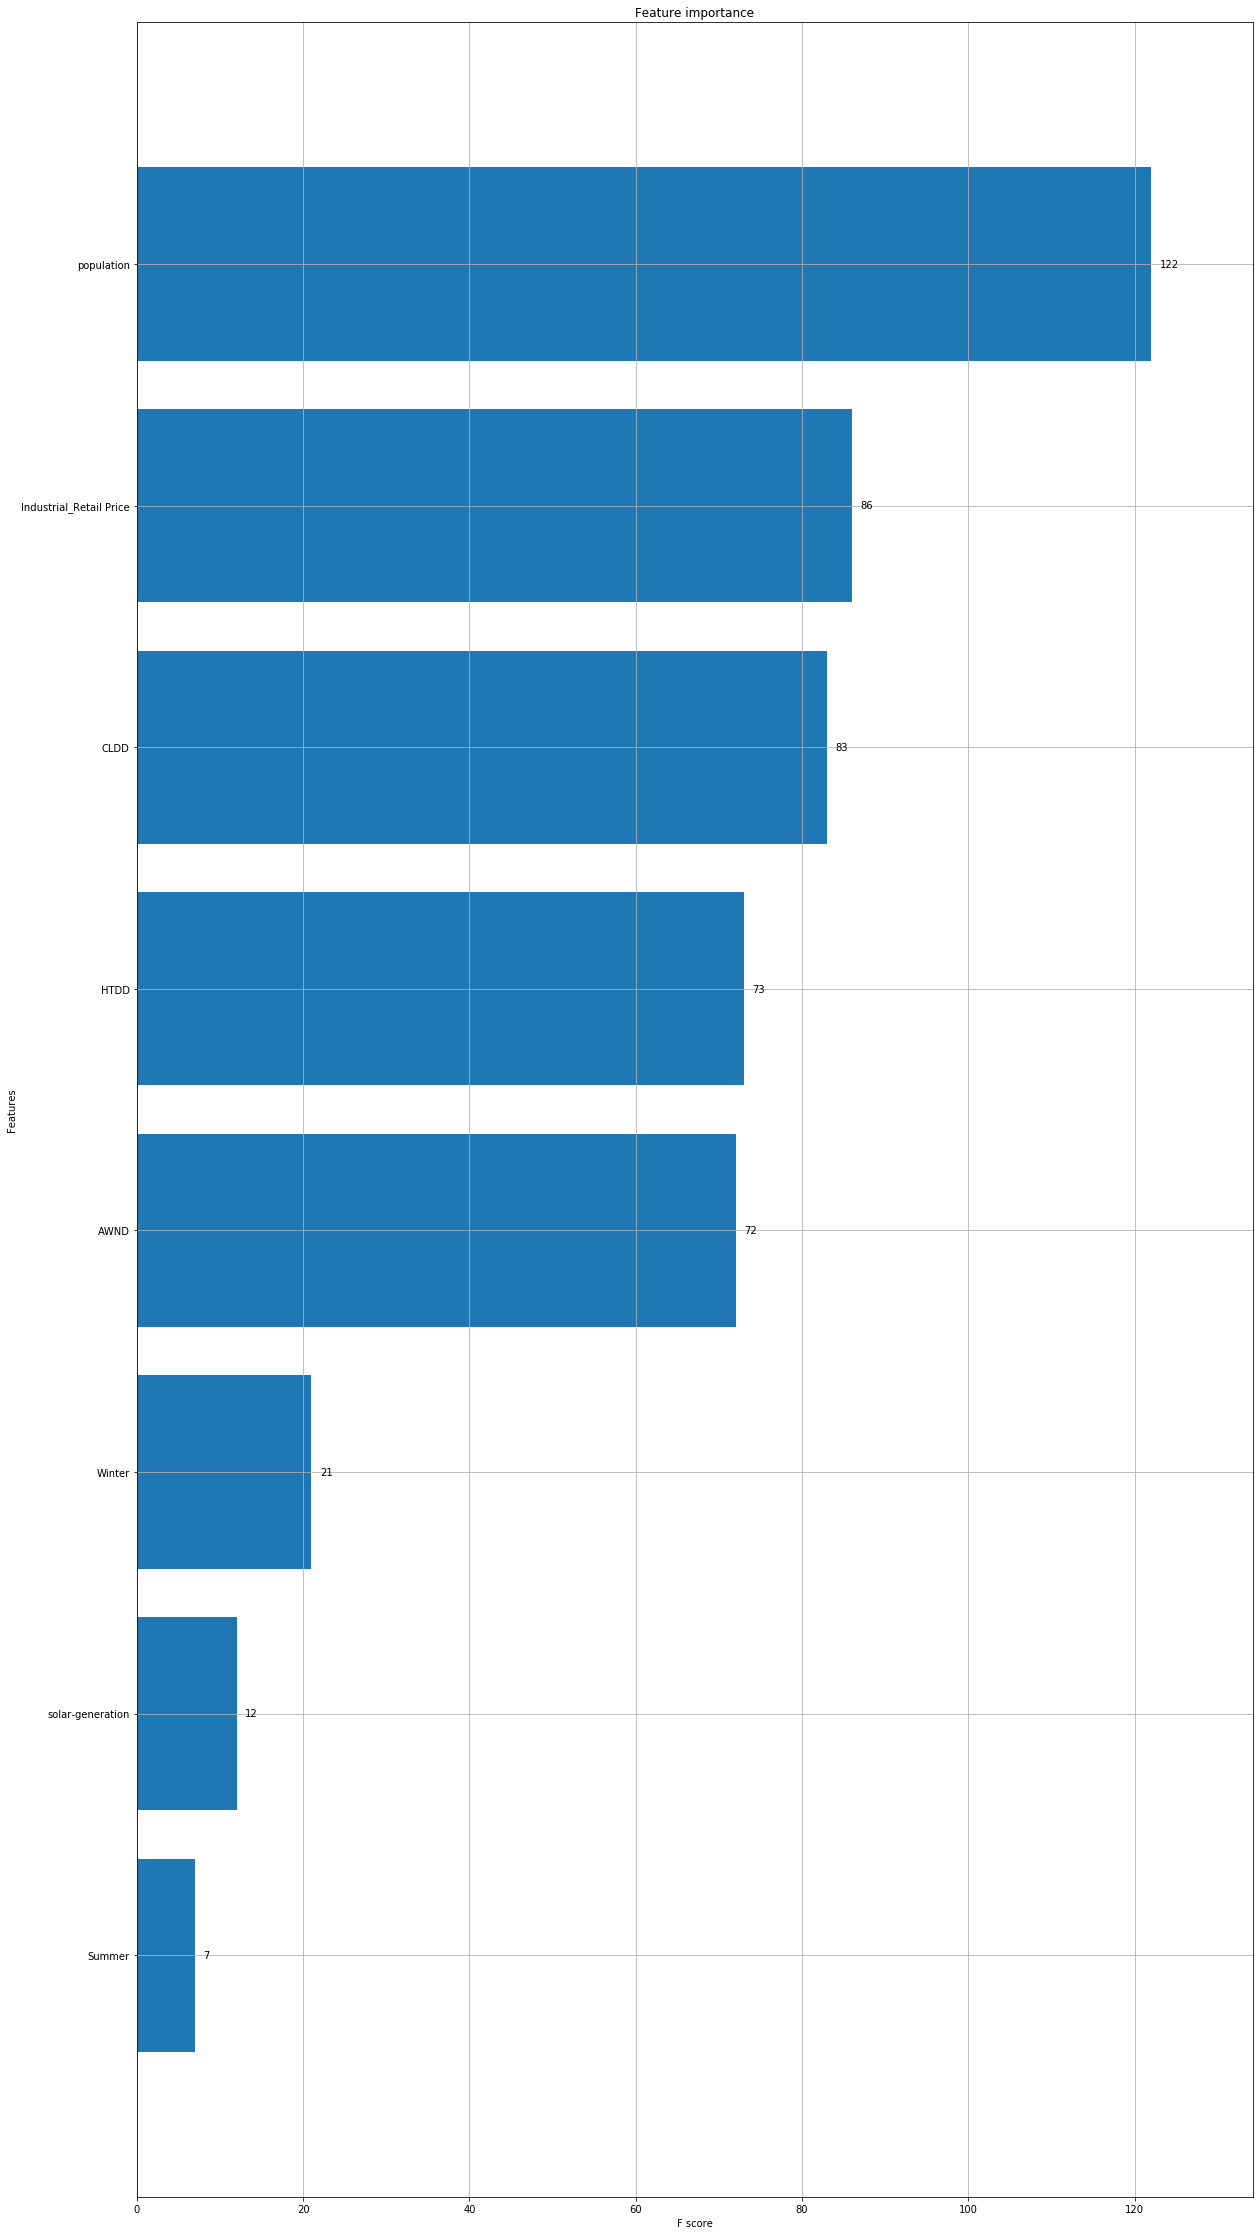

In [43]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_i, y_train_i)

fig, ax = plt.subplots(figsize=(20,40))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


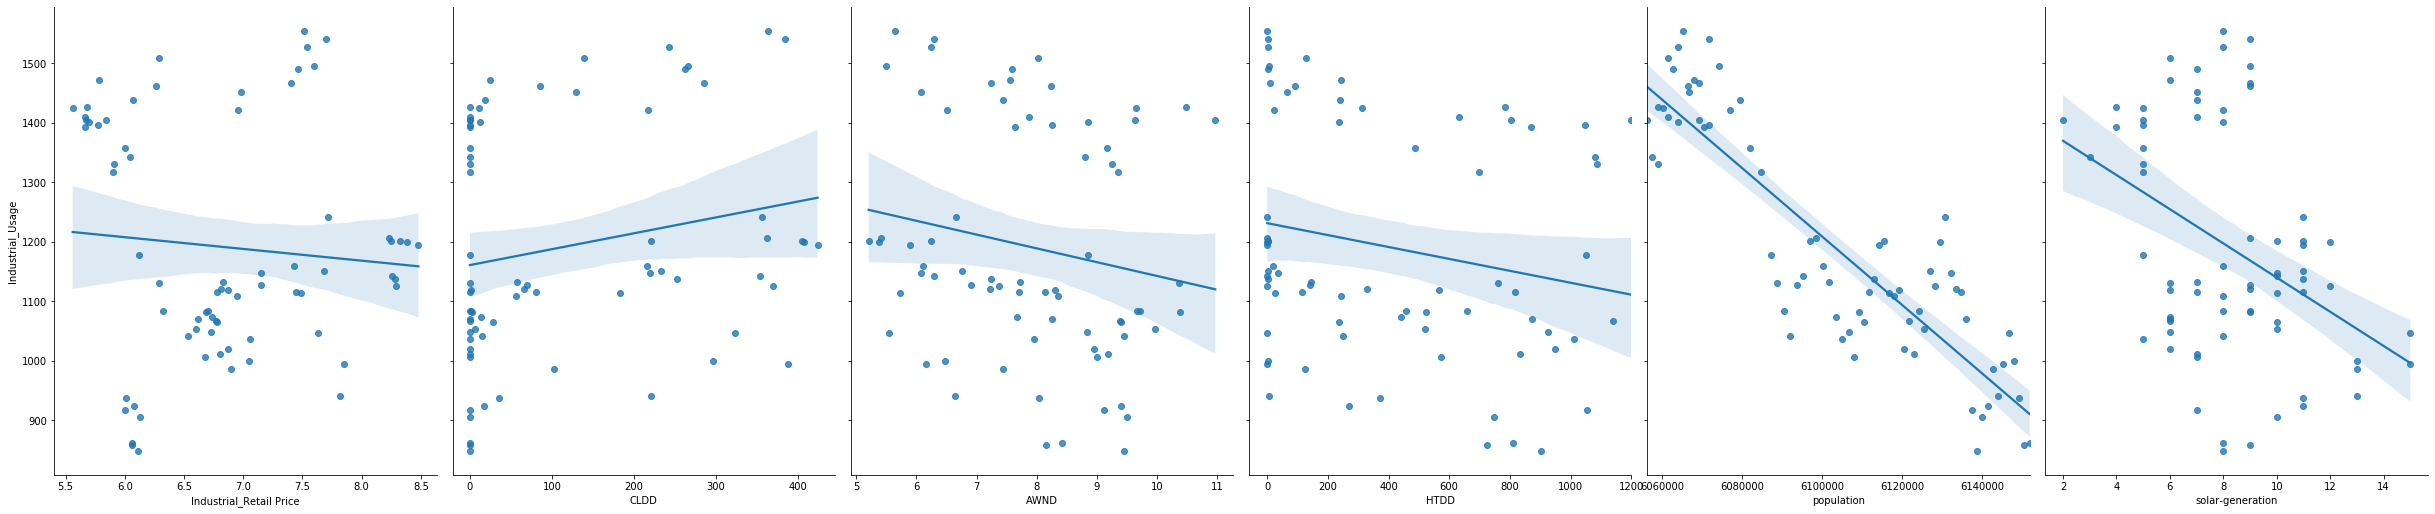

In [44]:
# Correlation Analysis
correlation_analysis(data_MO, industrial_numeric_columns_adj, ['Industrial_Usage'])

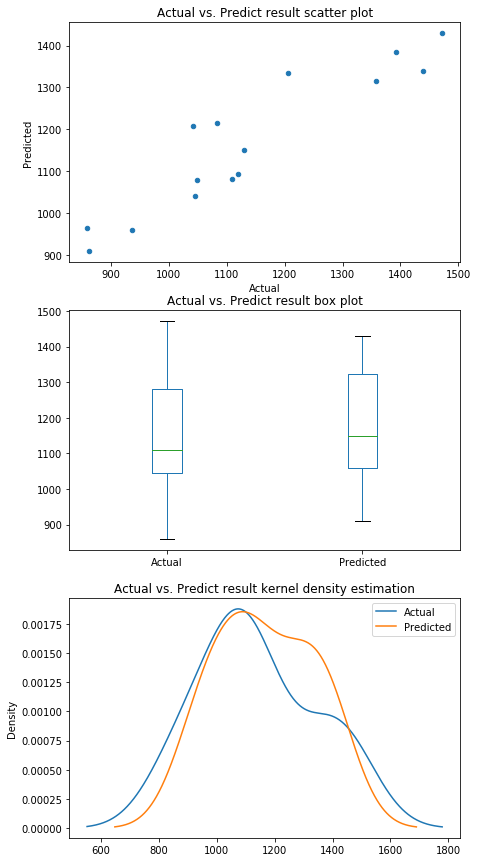

In [45]:
visualize_graph(df_pred_i)

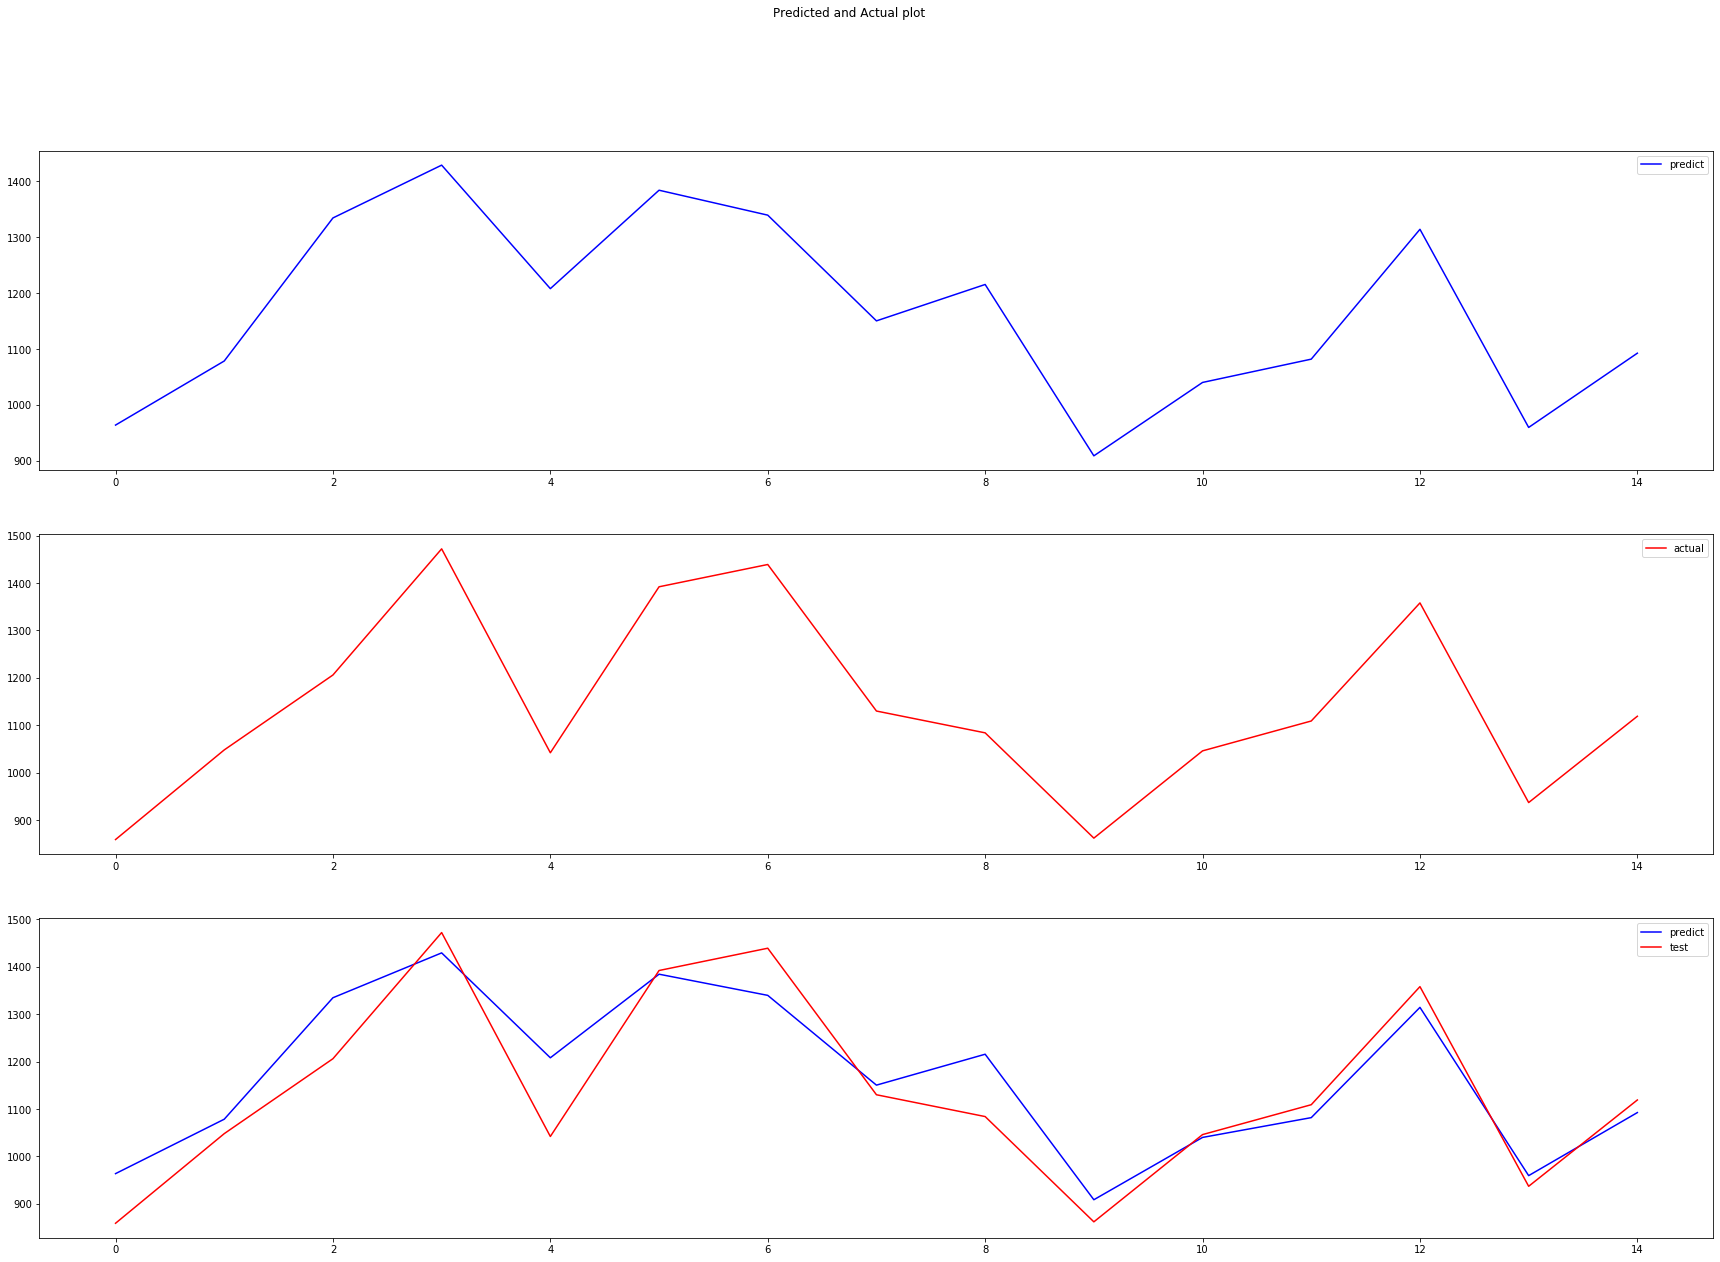

In [46]:
visualization(df_pred_i.Actual, df_pred_i.Predicted)

### Industrial_ANN

In [47]:
features_ANN_i=['Year', 'Month', 'Industrial_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Industrial_Retail Price']
#Spring is the seasonal feature baseline
data_MO_ANN=data[data.MO==1]
data_MO_ANN=data_MO_ANN[features_ANN_i]
data_MO_ANN

,Year,Month,Industrial_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Industrial_Retail Price
23,2014,1,1405,0.000000,10.964706,1200.807143,6056202,2,0,0,1,5.84
73,2014,2,1343,0.000000,8.800000,1081.209459,6057496,3,0,0,1,6.04
123,2014,3,1426,0.000000,10.482353,785.601351,6058790,4,0,0,0,5.68
173,2014,4,1425,10.979730,9.642105,312.655405,6060085,5,0,0,0,5.56
223,2014,5,1509,138.753333,8.021053,127.960000,6061379,6,0,0,0,6.29
...,...,...,...,...,...,...,...,...,...,...,...,...
3373,2019,8,1046,322.943262,5.540000,0.319149,6146648,15,1,0,0,7.63
3423,2019,9,1000,297.087591,6.470000,1.875912,6147965,13,0,1,0,7.05
3473,2019,10,937,35.781690,8.029412,370.436620,6149282,11,0,1,0,6.01
3523,2019,11,859,0.000000,8.158824,724.030075,6150599,9,0,1,0,6.06


In [48]:
train_ANN, test_ANN = train_test_split(data_MO_ANN, test_size=0.2)
X_train_ANN_i, y_train_ANN_i = x_y_split(train_ANN, 'Industrial_Usage', ['Industrial_Usage'])
X_test_ANN_i,y_test_ANN_i = x_y_split(test_ANN, 'Industrial_Usage', ['Industrial_Usage'])

In [49]:
X_train_ANN_i, X_test_ANN_i = minmax_scaler(X_train_ANN_i, X_test_ANN_i, industrial_numeric_columns_adj)
y_train_ANN_i = (y_train_ANN_i - min(y_train_ANN_i))/(max(y_train_ANN_i) - min(y_train_ANN_i))

In [50]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Adding the second hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_i, y_train_ANN_i, validation_split = 0.2, batch_size = 10, epochs = 900)

Train on 45 samples, validate on 12 samples
Epoch 1/900
45/45 [==============================] - 1s 22ms/step - loss: 0.0773 - mae: 0.2354 - val_loss: 0.0850 - val_mae: 0.2522
Epoch 2/900
45/45 [==============================] - 0s 465us/step - loss: 0.0752 - mae: 0.2304 - val_loss: 0.0871 - val_mae: 0.2498
Epoch 3/900
45/45 [==============================] - 0s 510us/step - loss: 0.0738 - mae: 0.2275 - val_loss: 0.0880 - val_mae: 0.2489
Epoch 4/900
45/45 [==============================] - 0s 532us/step - loss: 0.0736 - mae: 0.2258 - val_loss: 0.0903 - val_mae: 0.2469
Epoch 5/900
45/45 [==============================] - 0s 488us/step - loss: 0.0724 - mae: 0.2216 - val_loss: 0.0924 - val_mae: 0.2452
Epoch 6/900
45/45 [==============================] - 0s 465us/step - loss: 0.0730 - mae: 0.2188 - val_loss: 0.0964 - val_mae: 0.2423
Epoch 7/900
45/45 [==============================] - 0s 421us/step - loss: 0.0719 - mae: 0.2160 - val_loss: 0.0962 - val_mae: 0.2424
Epoch 8/900
45/45 [=======

Epoch 62/900
45/45 [==============================] - 0s 532us/step - loss: 0.0717 - mae: 0.2148 - val_loss: 0.0979 - val_mae: 0.2413
Epoch 63/900
45/45 [==============================] - 0s 576us/step - loss: 0.0720 - mae: 0.2132 - val_loss: 0.1002 - val_mae: 0.2411
Epoch 64/900
45/45 [==============================] - 0s 621us/step - loss: 0.0720 - mae: 0.2115 - val_loss: 0.1010 - val_mae: 0.2415
Epoch 65/900
45/45 [==============================] - 0s 510us/step - loss: 0.0723 - mae: 0.2112 - val_loss: 0.1009 - val_mae: 0.2415
Epoch 66/900
45/45 [==============================] - 0s 532us/step - loss: 0.0718 - mae: 0.2118 - val_loss: 0.0984 - val_mae: 0.2411
Epoch 67/900
45/45 [==============================] - 0s 554us/step - loss: 0.0717 - mae: 0.2138 - val_loss: 0.0973 - val_mae: 0.2417
Epoch 68/900
45/45 [==============================] - 0s 576us/step - loss: 0.0717 - mae: 0.2150 - val_loss: 0.0961 - val_mae: 0.2425
Epoch 69/900
45/45 [==============================] - 0s 576us

Epoch 123/900
45/45 [==============================] - 0s 465us/step - loss: 0.0715 - mae: 0.2145 - val_loss: 0.0974 - val_mae: 0.2416
Epoch 124/900
45/45 [==============================] - 0s 488us/step - loss: 0.0723 - mae: 0.2137 - val_loss: 0.0997 - val_mae: 0.2410
Epoch 125/900
45/45 [==============================] - 0s 465us/step - loss: 0.0716 - mae: 0.2119 - val_loss: 0.0990 - val_mae: 0.2410
Epoch 126/900
45/45 [==============================] - 0s 488us/step - loss: 0.0716 - mae: 0.2133 - val_loss: 0.0973 - val_mae: 0.2417
Epoch 127/900
45/45 [==============================] - 0s 510us/step - loss: 0.0716 - mae: 0.2148 - val_loss: 0.0961 - val_mae: 0.2424
Epoch 128/900
45/45 [==============================] - 0s 510us/step - loss: 0.0717 - mae: 0.2159 - val_loss: 0.0958 - val_mae: 0.2427
Epoch 129/900
45/45 [==============================] - 0s 510us/step - loss: 0.0718 - mae: 0.2150 - val_loss: 0.0979 - val_mae: 0.2413
Epoch 130/900
45/45 [==============================] - 

Epoch 184/900
45/45 [==============================] - 0s 443us/step - loss: 0.0711 - mae: 0.2117 - val_loss: 0.0979 - val_mae: 0.2413
Epoch 185/900
45/45 [==============================] - 0s 465us/step - loss: 0.0711 - mae: 0.2126 - val_loss: 0.0967 - val_mae: 0.2421
Epoch 186/900
45/45 [==============================] - 0s 488us/step - loss: 0.0711 - mae: 0.2134 - val_loss: 0.0974 - val_mae: 0.2416
Epoch 187/900
45/45 [==============================] - 0s 421us/step - loss: 0.0711 - mae: 0.2119 - val_loss: 0.0991 - val_mae: 0.2407
Epoch 188/900
45/45 [==============================] - 0s 421us/step - loss: 0.0711 - mae: 0.2111 - val_loss: 0.0992 - val_mae: 0.2407
Epoch 189/900
45/45 [==============================] - 0s 421us/step - loss: 0.0715 - mae: 0.2106 - val_loss: 0.1000 - val_mae: 0.2407
Epoch 190/900
45/45 [==============================] - 0s 421us/step - loss: 0.0711 - mae: 0.2122 - val_loss: 0.0958 - val_mae: 0.2427
Epoch 191/900
45/45 [==============================] - 

45/45 [==============================] - 0s 488us/step - loss: 0.0692 - mae: 0.2084 - val_loss: 0.0958 - val_mae: 0.2425
Epoch 245/900
45/45 [==============================] - 0s 465us/step - loss: 0.0698 - mae: 0.2066 - val_loss: 0.1005 - val_mae: 0.2397
Epoch 246/900
45/45 [==============================] - 0s 466us/step - loss: 0.0688 - mae: 0.2053 - val_loss: 0.0964 - val_mae: 0.2421
Epoch 247/900
45/45 [==============================] - 0s 465us/step - loss: 0.0692 - mae: 0.2122 - val_loss: 0.0902 - val_mae: 0.2468
Epoch 248/900
45/45 [==============================] - 0s 467us/step - loss: 0.0688 - mae: 0.2137 - val_loss: 0.0923 - val_mae: 0.2449
Epoch 249/900
45/45 [==============================] - 0s 489us/step - loss: 0.0684 - mae: 0.2109 - val_loss: 0.0943 - val_mae: 0.2435
Epoch 250/900
45/45 [==============================] - 0s 488us/step - loss: 0.0680 - mae: 0.2069 - val_loss: 0.0988 - val_mae: 0.2406
Epoch 251/900
45/45 [==============================] - 0s 466us/step 

45/45 [==============================] - 0s 488us/step - loss: 0.0610 - mae: 0.1947 - val_loss: 0.0915 - val_mae: 0.2449
Epoch 305/900
45/45 [==============================] - 0s 488us/step - loss: 0.0612 - mae: 0.1870 - val_loss: 0.0959 - val_mae: 0.2418
Epoch 306/900
45/45 [==============================] - 0s 488us/step - loss: 0.0602 - mae: 0.1892 - val_loss: 0.0900 - val_mae: 0.2501
Epoch 307/900
45/45 [==============================] - 0s 510us/step - loss: 0.0633 - mae: 0.2067 - val_loss: 0.0893 - val_mae: 0.2553
Epoch 308/900
45/45 [==============================] - 0s 510us/step - loss: 0.0600 - mae: 0.1937 - val_loss: 0.1039 - val_mae: 0.2397
Epoch 309/900
45/45 [==============================] - 0s 488us/step - loss: 0.0657 - mae: 0.1858 - val_loss: 0.1009 - val_mae: 0.2393
Epoch 310/900
45/45 [==============================] - 0s 532us/step - loss: 0.0632 - mae: 0.1994 - val_loss: 0.0899 - val_mae: 0.2533
Epoch 311/900
45/45 [==============================] - 0s 576us/step 

Epoch 365/900
45/45 [==============================] - 0s 443us/step - loss: 0.0510 - mae: 0.1621 - val_loss: 0.0934 - val_mae: 0.2597
Epoch 366/900
45/45 [==============================] - 0s 443us/step - loss: 0.0588 - mae: 0.1986 - val_loss: 0.0935 - val_mae: 0.2565
Epoch 367/900
45/45 [==============================] - 0s 465us/step - loss: 0.0514 - mae: 0.1691 - val_loss: 0.1105 - val_mae: 0.2552
Epoch 368/900
45/45 [==============================] - 0s 443us/step - loss: 0.0589 - mae: 0.1787 - val_loss: 0.0935 - val_mae: 0.2601
Epoch 369/900
45/45 [==============================] - 0s 421us/step - loss: 0.0548 - mae: 0.1858 - val_loss: 0.0976 - val_mae: 0.2487
Epoch 370/900
45/45 [==============================] - 0s 465us/step - loss: 0.0533 - mae: 0.1630 - val_loss: 0.0998 - val_mae: 0.2489
Epoch 371/900
45/45 [==============================] - 0s 443us/step - loss: 0.0542 - mae: 0.1736 - val_loss: 0.0944 - val_mae: 0.2549
Epoch 372/900
45/45 [==============================] - 

45/45 [==============================] - 0s 443us/step - loss: 0.0474 - mae: 0.1696 - val_loss: 0.0969 - val_mae: 0.2537
Epoch 426/900
45/45 [==============================] - 0s 465us/step - loss: 0.0474 - mae: 0.1645 - val_loss: 0.0959 - val_mae: 0.2545
Epoch 427/900
45/45 [==============================] - 0s 465us/step - loss: 0.0478 - mae: 0.1567 - val_loss: 0.0983 - val_mae: 0.2544
Epoch 428/900
45/45 [==============================] - 0s 443us/step - loss: 0.0449 - mae: 0.1592 - val_loss: 0.0932 - val_mae: 0.2592
Epoch 429/900
45/45 [==============================] - 0s 421us/step - loss: 0.0483 - mae: 0.1730 - val_loss: 0.0942 - val_mae: 0.2564
Epoch 430/900
45/45 [==============================] - 0s 443us/step - loss: 0.0461 - mae: 0.1629 - val_loss: 0.0949 - val_mae: 0.2555
Epoch 431/900
45/45 [==============================] - 0s 488us/step - loss: 0.0480 - mae: 0.1726 - val_loss: 0.0929 - val_mae: 0.2629
Epoch 432/900
45/45 [==============================] - 0s 443us/step 

45/45 [==============================] - 0s 421us/step - loss: 0.0451 - mae: 0.1607 - val_loss: 0.0899 - val_mae: 0.2501
Epoch 486/900
45/45 [==============================] - 0s 443us/step - loss: 0.0410 - mae: 0.1609 - val_loss: 0.0878 - val_mae: 0.2526
Epoch 487/900
45/45 [==============================] - 0s 443us/step - loss: 0.0431 - mae: 0.1582 - val_loss: 0.0922 - val_mae: 0.2490
Epoch 488/900
45/45 [==============================] - 0s 443us/step - loss: 0.0405 - mae: 0.1580 - val_loss: 0.0868 - val_mae: 0.2560
Epoch 489/900
45/45 [==============================] - 0s 466us/step - loss: 0.0414 - mae: 0.1574 - val_loss: 0.0935 - val_mae: 0.2490
Epoch 490/900
45/45 [==============================] - 0s 465us/step - loss: 0.0394 - mae: 0.1492 - val_loss: 0.0865 - val_mae: 0.2555
Epoch 491/900
45/45 [==============================] - 0s 443us/step - loss: 0.0535 - mae: 0.1990 - val_loss: 0.0869 - val_mae: 0.2632
Epoch 492/900
45/45 [==============================] - 0s 421us/step 

Epoch 546/900
45/45 [==============================] - 0s 554us/step - loss: 0.0349 - mae: 0.1516 - val_loss: 0.0772 - val_mae: 0.2378
Epoch 547/900
45/45 [==============================] - ETA: 0s - loss: 0.0187 - mae: 0.108 - 0s 443us/step - loss: 0.0335 - mae: 0.1456 - val_loss: 0.0808 - val_mae: 0.2352
Epoch 548/900
45/45 [==============================] - 0s 510us/step - loss: 0.0353 - mae: 0.1449 - val_loss: 0.0765 - val_mae: 0.2376
Epoch 549/900
45/45 [==============================] - 0s 532us/step - loss: 0.0366 - mae: 0.1571 - val_loss: 0.0857 - val_mae: 0.2347
Epoch 550/900
45/45 [==============================] - 0s 510us/step - loss: 0.0423 - mae: 0.1508 - val_loss: 0.0760 - val_mae: 0.2456
Epoch 551/900
45/45 [==============================] - 0s 532us/step - loss: 0.0528 - mae: 0.2027 - val_loss: 0.0808 - val_mae: 0.2643
Epoch 552/900
45/45 [==============================] - 0s 532us/step - loss: 0.0408 - mae: 0.1664 - val_loss: 0.0971 - val_mae: 0.2440
Epoch 553/900
45/

45/45 [==============================] - 0s 465us/step - loss: 0.0287 - mae: 0.1369 - val_loss: 0.0639 - val_mae: 0.2215
Epoch 607/900
45/45 [==============================] - 0s 465us/step - loss: 0.0284 - mae: 0.1389 - val_loss: 0.0721 - val_mae: 0.2171
Epoch 608/900
45/45 [==============================] - 0s 488us/step - loss: 0.0307 - mae: 0.1299 - val_loss: 0.0634 - val_mae: 0.2214
Epoch 609/900
45/45 [==============================] - 0s 465us/step - loss: 0.0300 - mae: 0.1421 - val_loss: 0.0680 - val_mae: 0.2171
Epoch 610/900
45/45 [==============================] - 0s 488us/step - loss: 0.0279 - mae: 0.1331 - val_loss: 0.0646 - val_mae: 0.2172
Epoch 611/900
45/45 [==============================] - 0s 510us/step - loss: 0.0290 - mae: 0.1408 - val_loss: 0.0691 - val_mae: 0.2160
Epoch 612/900
45/45 [==============================] - 0s 532us/step - loss: 0.0319 - mae: 0.1347 - val_loss: 0.0628 - val_mae: 0.2233
Epoch 613/900
45/45 [==============================] - 0s 488us/step 

Epoch 667/900
45/45 [==============================] - 0s 510us/step - loss: 0.0242 - mae: 0.1301 - val_loss: 0.0553 - val_mae: 0.1985
Epoch 668/900
45/45 [==============================] - 0s 465us/step - loss: 0.0249 - mae: 0.1301 - val_loss: 0.0602 - val_mae: 0.1977
Epoch 669/900
45/45 [==============================] - 0s 465us/step - loss: 0.0260 - mae: 0.1260 - val_loss: 0.0521 - val_mae: 0.2025
Epoch 670/900
45/45 [==============================] - 0s 488us/step - loss: 0.0264 - mae: 0.1402 - val_loss: 0.0661 - val_mae: 0.2011
Epoch 671/900
45/45 [==============================] - 0s 443us/step - loss: 0.0330 - mae: 0.1453 - val_loss: 0.0522 - val_mae: 0.2057
Epoch 672/900
45/45 [==============================] - 0s 466us/step - loss: 0.0266 - mae: 0.1300 - val_loss: 0.0547 - val_mae: 0.1968
Epoch 673/900
45/45 [==============================] - 0s 465us/step - loss: 0.0246 - mae: 0.1294 - val_loss: 0.0536 - val_mae: 0.1966
Epoch 674/900
45/45 [==============================] - 

Epoch 728/900
45/45 [==============================] - 0s 510us/step - loss: 0.0218 - mae: 0.1291 - val_loss: 0.0465 - val_mae: 0.1805
Epoch 729/900
45/45 [==============================] - 0s 510us/step - loss: 0.0228 - mae: 0.1246 - val_loss: 0.0433 - val_mae: 0.1818
Epoch 730/900
45/45 [==============================] - 0s 510us/step - loss: 0.0215 - mae: 0.1236 - val_loss: 0.0506 - val_mae: 0.1816
Epoch 731/900
45/45 [==============================] - 0s 465us/step - loss: 0.0229 - mae: 0.1206 - val_loss: 0.0441 - val_mae: 0.1909
Epoch 732/900
45/45 [==============================] - 0s 465us/step - loss: 0.0252 - mae: 0.1354 - val_loss: 0.0489 - val_mae: 0.1795
Epoch 733/900
45/45 [==============================] - 0s 488us/step - loss: 0.0229 - mae: 0.1231 - val_loss: 0.0439 - val_mae: 0.1905
Epoch 734/900
45/45 [==============================] - 0s 510us/step - loss: 0.0236 - mae: 0.1306 - val_loss: 0.0552 - val_mae: 0.1858
Epoch 735/900
45/45 [==============================] - 

45/45 [==============================] - 0s 554us/step - loss: 0.0198 - mae: 0.1182 - val_loss: 0.0428 - val_mae: 0.1697
Epoch 789/900
45/45 [==============================] - 0s 576us/step - loss: 0.0228 - mae: 0.1294 - val_loss: 0.0362 - val_mae: 0.1679
Epoch 790/900
45/45 [==============================] - 0s 576us/step - loss: 0.0178 - mae: 0.1106 - val_loss: 0.0411 - val_mae: 0.1675
Epoch 791/900
45/45 [==============================] - 0s 576us/step - loss: 0.0185 - mae: 0.1143 - val_loss: 0.0374 - val_mae: 0.1746
Epoch 792/900
45/45 [==============================] - 0s 598us/step - loss: 0.0196 - mae: 0.1180 - val_loss: 0.0405 - val_mae: 0.1665
Epoch 793/900
45/45 [==============================] - 0s 510us/step - loss: 0.0183 - mae: 0.1131 - val_loss: 0.0359 - val_mae: 0.1663
Epoch 794/900
45/45 [==============================] - 0s 510us/step - loss: 0.0188 - mae: 0.1141 - val_loss: 0.0363 - val_mae: 0.1659
Epoch 795/900
45/45 [==============================] - 0s 576us/step 

45/45 [==============================] - 0s 621us/step - loss: 0.0205 - mae: 0.1278 - val_loss: 0.0390 - val_mae: 0.1628
Epoch 849/900
45/45 [==============================] - 0s 465us/step - loss: 0.0218 - mae: 0.1227 - val_loss: 0.0314 - val_mae: 0.1566
Epoch 850/900
45/45 [==============================] - 0s 510us/step - loss: 0.0186 - mae: 0.1152 - val_loss: 0.0316 - val_mae: 0.1565
Epoch 851/900
45/45 [==============================] - 0s 465us/step - loss: 0.0230 - mae: 0.1319 - val_loss: 0.0378 - val_mae: 0.1607
Epoch 852/900
45/45 [==============================] - 0s 465us/step - loss: 0.0199 - mae: 0.1230 - val_loss: 0.0313 - val_mae: 0.1563
Epoch 853/900
45/45 [==============================] - 0s 465us/step - loss: 0.0184 - mae: 0.1146 - val_loss: 0.0313 - val_mae: 0.1560
Epoch 854/900
45/45 [==============================] - 0s 488us/step - loss: 0.0164 - mae: 0.1078 - val_loss: 0.0311 - val_mae: 0.1558
Epoch 855/900
45/45 [==============================] - 0s 443us/step 

In [51]:
# Predicting the Test set results
predictions_ANN_i = classifier.predict(X_test_ANN_i)
# Scale y back 
predictions_ANN_i = (predictions_ANN_i * (max(y_test_ANN_i) - min(y_test_ANN_i))) + min(y_test_ANN_i)
predictions_ANN_i = predictions_ANN_i.reshape(-1)
df_pred_ANN_i = pd.DataFrame({'Actual': y_test_ANN_i, 'Predicted': predictions_ANN_i})

In [52]:
df_pred_ANN_i

,Actual,Predicted
2373,1019,1118.943115
73,1343,1376.457520
1823,1048,1192.850708
173,1425,1402.559448
373,1554,1402.559448
723,1409,1402.559448
1173,1318,1250.433960
673,1331,1349.024902
2823,1148,1233.406494
1223,1177,1265.827637


In [53]:
evaluate_performances(y_test_ANN_i, predictions_ANN_i)

Performance Evaluation
Mean Absolute Error: 77.47588704427083
Mean Squared Error: 9196.777222554882
Root Mean Squared Error: 95.89982910597328


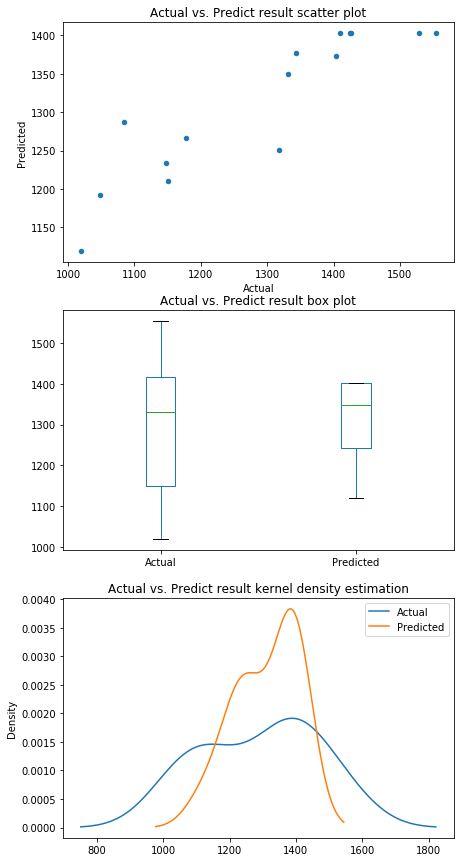

In [54]:
visualize_graph(df_pred_ANN_i)

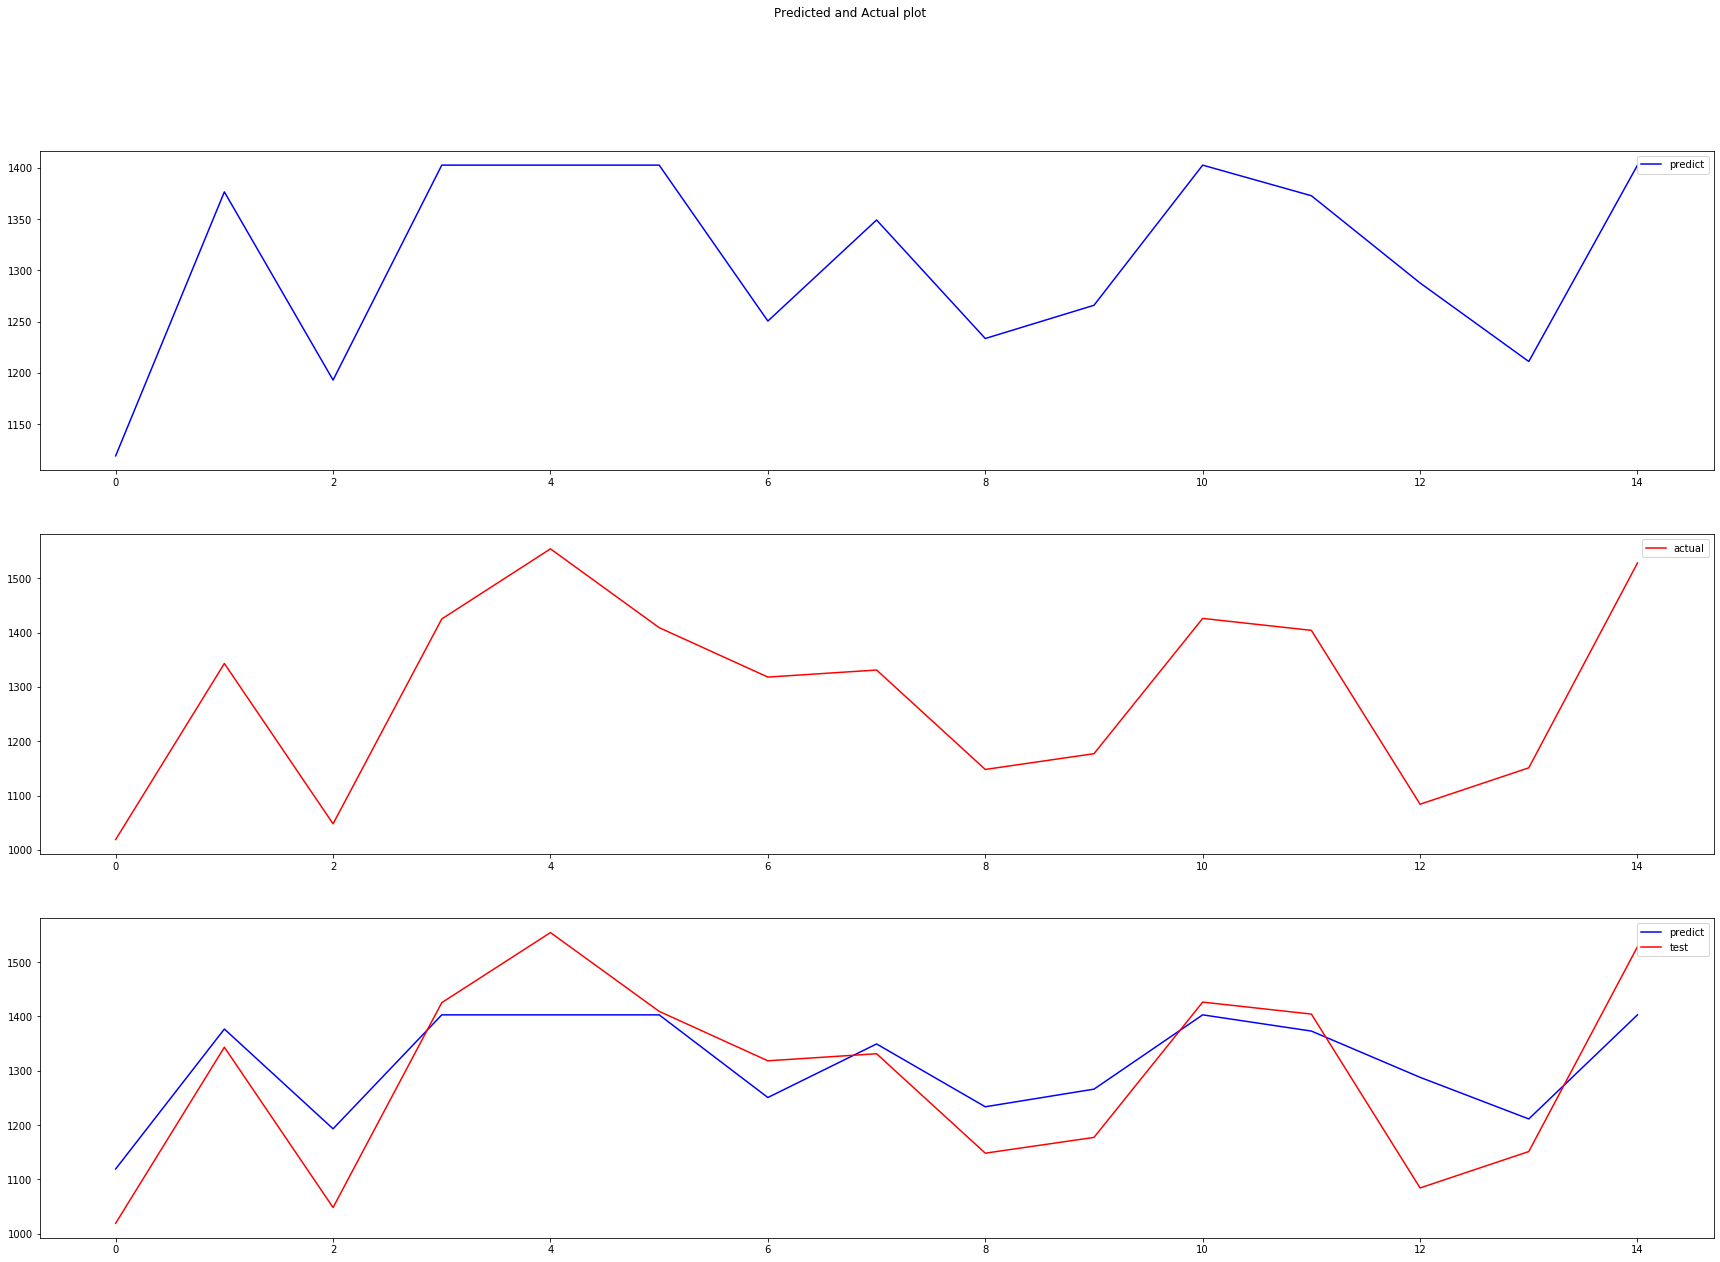

In [55]:
visualization(df_pred_ANN_i.Actual, df_pred_ANN_i.Predicted)

## Residential Consumption Forecast

In [56]:
df_pred_r=sm_regression(X_train_r, y_train_r, X_test_r, y_test_r)

                            OLS Regression Results                            
Dep. Variable:      Residential_Usage   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     74.51
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           8.98e-25
Time:                        06:06:12   Log-Likelihood:                -366.13
No. Observations:                  57   AIC:                             752.3
Df Residuals:                      47   BIC:                             772.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [57]:
df_pred_r

,Actual,Predicted
3523,2619.0,2847.800970
1823,3439.0,3353.977436
1573,3759.0,3686.637133
473,2087.0,2183.706053
1373,1960.0,2077.585253
573,3329.0,3409.224258
1073,2059.0,2060.789406
1273,3063.0,3020.504963
1323,2385.0,2339.237272
3573,3129.0,3229.818372


In [58]:
evaluate_performances(df_pred_r['Actual'], df_pred_r['Predicted'])

Performance Evaluation
Mean Absolute Error: 82.5264686316698
Mean Squared Error: 9678.704641913197
Root Mean Squared Error: 98.38040781534298


## Residential_Feature Importance

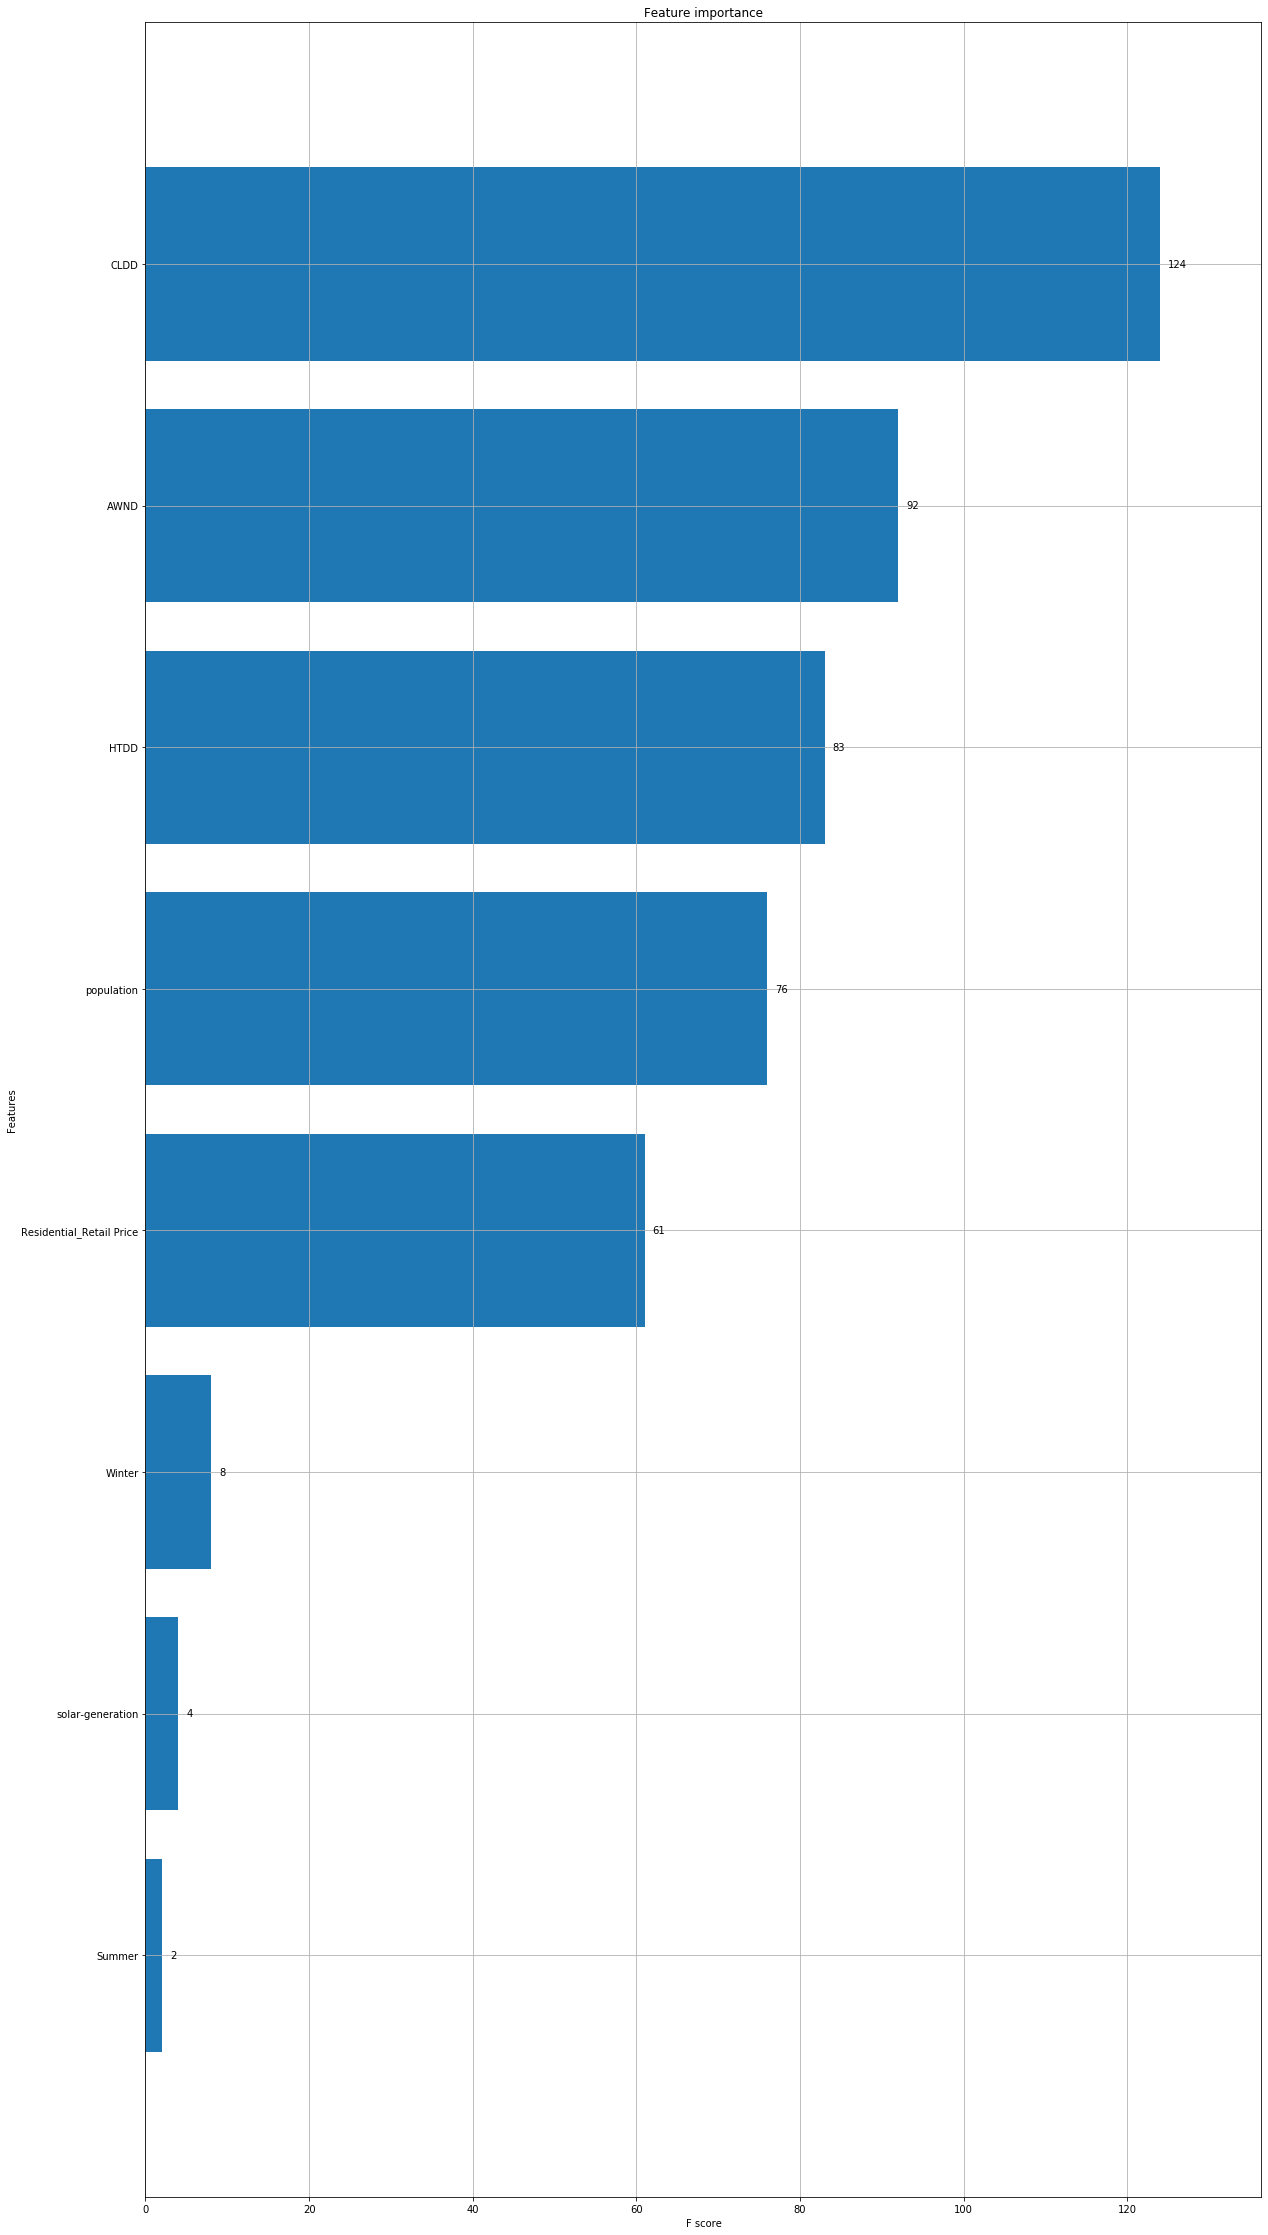

In [59]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train_r, y_train_r)

fig, ax = plt.subplots(figsize=(20,40))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


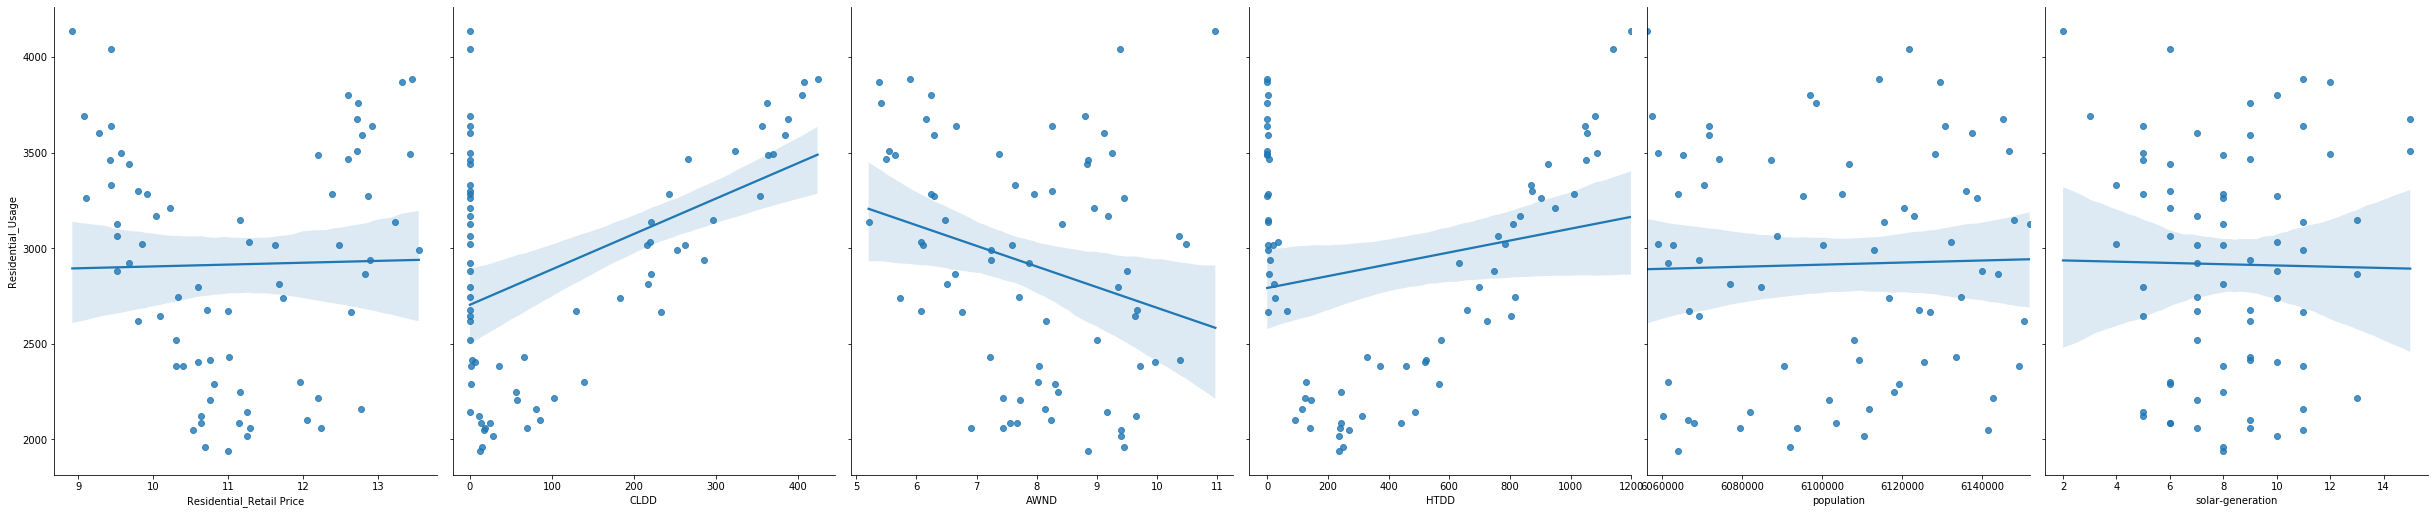

In [60]:
# Correlation Analysis
correlation_analysis(data_MO, residential_numeric_columns_adj, ['Residential_Usage'])

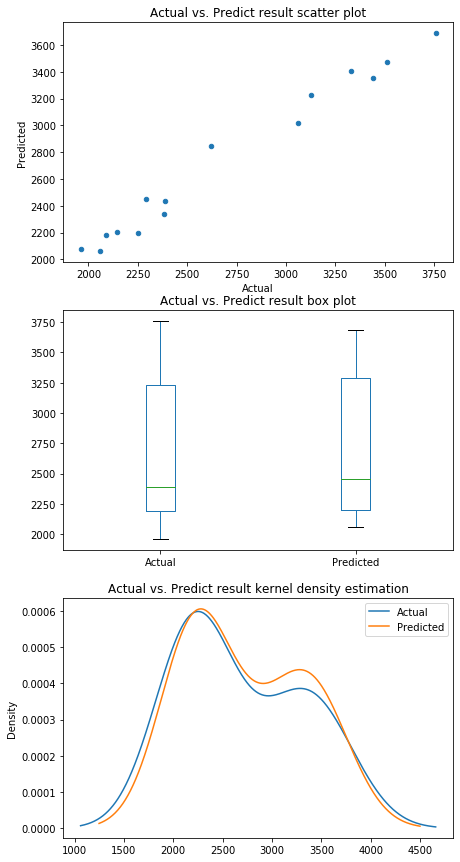

In [61]:
visualize_graph(df_pred_r)

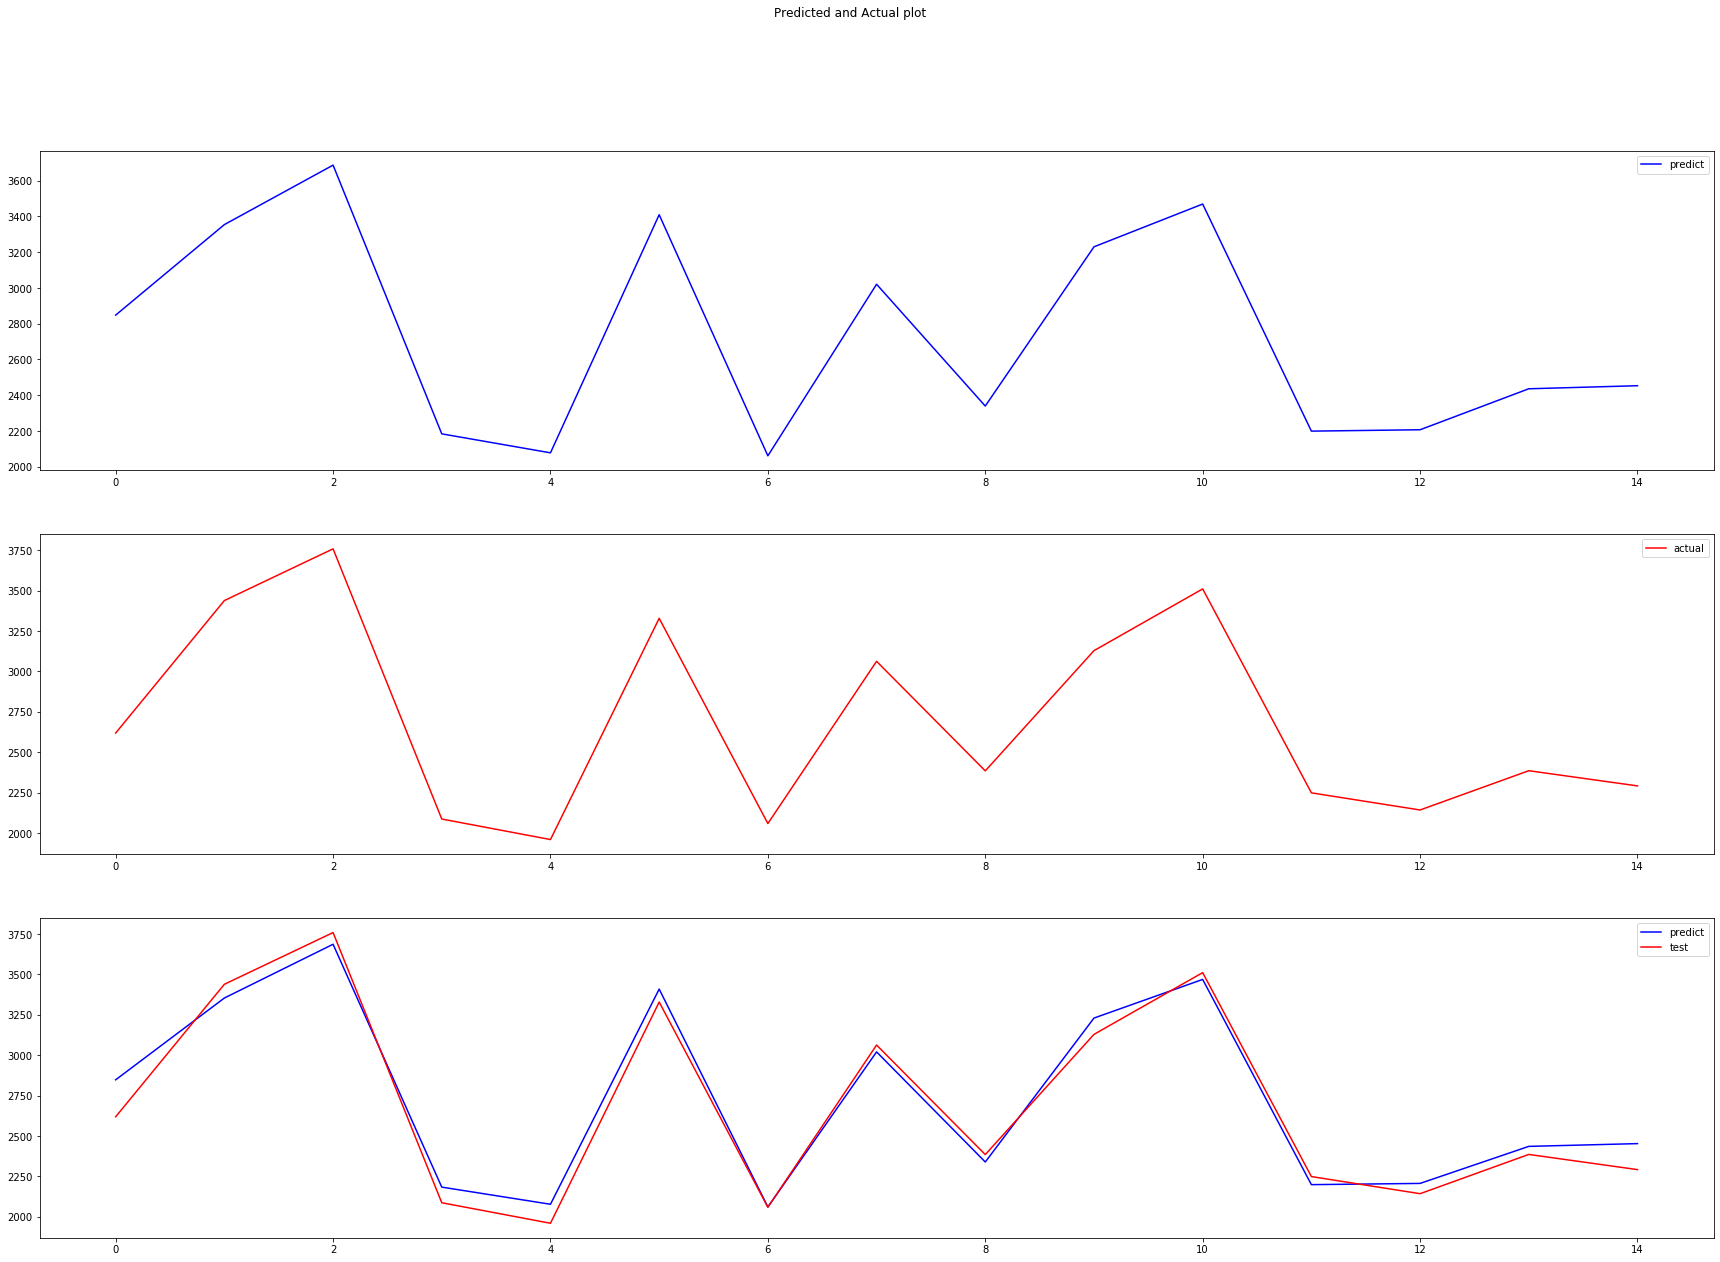

In [62]:
visualization(df_pred_r.Actual, df_pred_r.Predicted)

### Residential_ANN

In [63]:
features_ANN_r=['Year', 'Month', 'Residential_Usage', 'CLDD', 'AWND', 'HTDD', 'population', 'solar-generation','Summer', 'Fall', 'Winter', 'Residential_Retail Price']
#Spring is the seasonal feature baseline
data_MO_ANN=data[data.MO==1]
data_MO_ANN=data_MO_ANN[features_ANN_r]
data_MO_ANN


,Year,Month,Residential_Usage,CLDD,AWND,HTDD,population,solar-generation,Summer,Fall,Winter,Residential_Retail Price
23,2014,1,4136.0,0.000000,10.964706,1200.807143,6056202,2,0,0,1,8.92
73,2014,2,3694.0,0.000000,8.800000,1081.209459,6057496,3,0,0,1,9.08
123,2014,3,3024.0,0.000000,10.482353,785.601351,6058790,4,0,0,0,9.85
173,2014,4,2120.0,10.979730,9.642105,312.655405,6060085,5,0,0,0,10.63
223,2014,5,2300.0,138.753333,8.021053,127.960000,6061379,6,0,0,0,11.95
...,...,...,...,...,...,...,...,...,...,...,...,...
3373,2019,8,3511.0,322.943262,5.540000,0.319149,6146648,15,1,0,0,12.71
3423,2019,9,3148.0,297.087591,6.470000,1.875912,6147965,13,0,1,0,11.15
3473,2019,10,2386.0,35.781690,8.029412,370.436620,6149282,11,0,1,0,10.30
3523,2019,11,2619.0,0.000000,8.158824,724.030075,6150599,9,0,1,0,9.79


In [64]:
train_ANN, test_ANN = train_test_split(data_MO_ANN, test_size=0.2)
X_train_ANN_r, y_train_ANN_r = x_y_split(train_ANN, 'Residential_Usage', ['Residential_Usage'])
X_test_ANN_r,y_test_ANN_r = x_y_split(test_ANN, 'Residential_Usage', ['Residential_Usage'])


In [65]:
X_train_ANN_r, X_test_ANN_r = minmax_scaler(X_train_ANN_r, X_test_ANN_r, residential_numeric_columns_adj)
y_train_ANN_r = (y_train_ANN_r - min(y_train_ANN_r))/(max(y_train_ANN_r) - min(y_train_ANN_r))


In [66]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))

# Adding the second hidden layer
# classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X_train_ANN_r, y_train_ANN_r, validation_split = 0.2, batch_size = 10, epochs = 1200)


Train on 45 samples, validate on 12 samples
Epoch 1/1200
45/45 [==============================] - 1s 22ms/step - loss: 0.0983 - mae: 0.2733 - val_loss: 0.0737 - val_mae: 0.2004
Epoch 2/1200
45/45 [==============================] - 0s 487us/step - loss: 0.0857 - mae: 0.2569 - val_loss: 0.0670 - val_mae: 0.1887
Epoch 3/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0804 - mae: 0.2501 - val_loss: 0.0643 - val_mae: 0.1891
Epoch 4/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0793 - mae: 0.2474 - val_loss: 0.0635 - val_mae: 0.1923
Epoch 5/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0792 - mae: 0.2463 - val_loss: 0.0635 - val_mae: 0.1935
Epoch 6/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0793 - mae: 0.2462 - val_loss: 0.0635 - val_mae: 0.1928
Epoch 7/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0800 - mae: 0.2471 - val_loss: 0.0635 - val_mae: 0.1937
Epoch 8/1200
45/45 

45/45 [==============================] - 0s 399us/step - loss: 0.0789 - mae: 0.2478 - val_loss: 0.0642 - val_mae: 0.1882
Epoch 62/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0791 - mae: 0.2482 - val_loss: 0.0642 - val_mae: 0.1881
Epoch 63/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0791 - mae: 0.2481 - val_loss: 0.0638 - val_mae: 0.1894
Epoch 64/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0786 - mae: 0.2467 - val_loss: 0.0636 - val_mae: 0.1900
Epoch 65/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0786 - mae: 0.2466 - val_loss: 0.0636 - val_mae: 0.1900
Epoch 66/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0787 - mae: 0.2465 - val_loss: 0.0636 - val_mae: 0.1904
Epoch 67/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0785 - mae: 0.2461 - val_loss: 0.0635 - val_mae: 0.1906
Epoch 68/1200
45/45 [==============================] - 0s 465us/step 

45/45 [==============================] - 0s 465us/step - loss: 0.0768 - mae: 0.2388 - val_loss: 0.0627 - val_mae: 0.1927
Epoch 122/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0746 - mae: 0.2370 - val_loss: 0.0631 - val_mae: 0.1816
Epoch 123/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0740 - mae: 0.2403 - val_loss: 0.0638 - val_mae: 0.1813
Epoch 124/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0745 - mae: 0.2417 - val_loss: 0.0632 - val_mae: 0.1810
Epoch 125/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0742 - mae: 0.2407 - val_loss: 0.0633 - val_mae: 0.1806
Epoch 126/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0731 - mae: 0.2389 - val_loss: 0.0625 - val_mae: 0.1814
Epoch 127/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0732 - mae: 0.2372 - val_loss: 0.0623 - val_mae: 0.1824
Epoch 128/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 465us/step - loss: 0.0569 - mae: 0.2070 - val_loss: 0.0564 - val_mae: 0.1864
Epoch 182/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0610 - mae: 0.2145 - val_loss: 0.0651 - val_mae: 0.1877
Epoch 183/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0529 - mae: 0.1992 - val_loss: 0.0562 - val_mae: 0.1724
Epoch 184/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0541 - mae: 0.2014 - val_loss: 0.0594 - val_mae: 0.1762
Epoch 185/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0562 - mae: 0.2021 - val_loss: 0.0611 - val_mae: 0.1813
Epoch 186/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0542 - mae: 0.2033 - val_loss: 0.0561 - val_mae: 0.1718
Epoch 187/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0540 - mae: 0.2001 - val_loss: 0.0638 - val_mae: 0.1880
Epoch 188/1200
45/45 [==============================] - 0s 510u

45/45 [==============================] - 0s 443us/step - loss: 0.0568 - mae: 0.1958 - val_loss: 0.0622 - val_mae: 0.1931
Epoch 242/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0645 - mae: 0.2088 - val_loss: 0.0466 - val_mae: 0.1820
Epoch 243/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0763 - mae: 0.2236 - val_loss: 0.0892 - val_mae: 0.2347
Epoch 244/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0572 - mae: 0.1938 - val_loss: 0.0511 - val_mae: 0.1995
Epoch 245/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0503 - mae: 0.1867 - val_loss: 0.0727 - val_mae: 0.2093
Epoch 246/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0539 - mae: 0.1876 - val_loss: 0.0468 - val_mae: 0.1653
Epoch 247/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0629 - mae: 0.2093 - val_loss: 0.0450 - val_mae: 0.1711
Epoch 248/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 443us/step - loss: 0.0436 - mae: 0.1764 - val_loss: 0.0379 - val_mae: 0.1556
Epoch 302/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0347 - mae: 0.1527 - val_loss: 0.0338 - val_mae: 0.1546
Epoch 303/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0376 - mae: 0.1523 - val_loss: 0.0376 - val_mae: 0.1553
Epoch 304/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0540 - mae: 0.1850 - val_loss: 0.0341 - val_mae: 0.1540
Epoch 305/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0381 - mae: 0.1588 - val_loss: 0.0493 - val_mae: 0.1743
Epoch 306/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0341 - mae: 0.1573 - val_loss: 0.0325 - val_mae: 0.1527
Epoch 307/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0356 - mae: 0.1567 - val_loss: 0.0396 - val_mae: 0.1583
Epoch 308/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 443us/step - loss: 0.0243 - mae: 0.1268 - val_loss: 0.0297 - val_mae: 0.1508
Epoch 362/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0237 - mae: 0.1255 - val_loss: 0.0256 - val_mae: 0.1425
Epoch 363/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0245 - mae: 0.1265 - val_loss: 0.0280 - val_mae: 0.1482
Epoch 364/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0270 - mae: 0.1388 - val_loss: 0.0278 - val_mae: 0.1477
Epoch 365/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0229 - mae: 0.1234 - val_loss: 0.0327 - val_mae: 0.1571
Epoch 366/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0230 - mae: 0.1221 - val_loss: 0.0255 - val_mae: 0.1387
Epoch 367/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0312 - mae: 0.1450 - val_loss: 0.0405 - val_mae: 0.1705
Epoch 368/1200
45/45 [==============================] - 0s 443u

Epoch 421/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0204 - mae: 0.1132 - val_loss: 0.0236 - val_mae: 0.1379
Epoch 422/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0218 - mae: 0.1182 - val_loss: 0.0283 - val_mae: 0.1573
Epoch 423/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0234 - mae: 0.1206 - val_loss: 0.0229 - val_mae: 0.1351
Epoch 424/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0251 - mae: 0.1232 - val_loss: 0.0335 - val_mae: 0.1684
Epoch 425/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0253 - mae: 0.1288 - val_loss: 0.0235 - val_mae: 0.1349
Epoch 426/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0254 - mae: 0.1267 - val_loss: 0.0305 - val_mae: 0.1593
Epoch 427/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0298 - mae: 0.1375 - val_loss: 0.0237 - val_mae: 0.1342
Epoch 428/1200
45/45 [==========================

45/45 [==============================] - 0s 421us/step - loss: 0.0198 - mae: 0.1076 - val_loss: 0.0231 - val_mae: 0.1368
Epoch 482/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0247 - mae: 0.1251 - val_loss: 0.0292 - val_mae: 0.1628
Epoch 483/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0199 - mae: 0.1122 - val_loss: 0.0252 - val_mae: 0.1498
Epoch 484/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0214 - mae: 0.1138 - val_loss: 0.0273 - val_mae: 0.1584
Epoch 485/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0233 - mae: 0.1243 - val_loss: 0.0252 - val_mae: 0.1511
Epoch 486/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0223 - mae: 0.1199 - val_loss: 0.0266 - val_mae: 0.1548
Epoch 487/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0213 - mae: 0.1170 - val_loss: 0.0242 - val_mae: 0.1449
Epoch 488/1200
45/45 [==============================] - 0s 465u

45/45 [==============================] - 0s 443us/step - loss: 0.0209 - mae: 0.1172 - val_loss: 0.0242 - val_mae: 0.1459
Epoch 542/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0190 - mae: 0.1064 - val_loss: 0.0240 - val_mae: 0.1441
Epoch 543/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0173 - mae: 0.1001 - val_loss: 0.0234 - val_mae: 0.1398
Epoch 544/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0167 - mae: 0.1001 - val_loss: 0.0245 - val_mae: 0.1486
Epoch 545/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0185 - mae: 0.1084 - val_loss: 0.0238 - val_mae: 0.1428
Epoch 546/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0202 - mae: 0.1125 - val_loss: 0.0254 - val_mae: 0.1515
Epoch 547/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0163 - mae: 0.1003 - val_loss: 0.0250 - val_mae: 0.1497
Epoch 548/1200
45/45 [==============================] - 0s 421u

45/45 [==============================] - 0s 443us/step - loss: 0.0187 - mae: 0.1092 - val_loss: 0.0288 - val_mae: 0.1342
Epoch 602/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0242 - mae: 0.1279 - val_loss: 0.0476 - val_mae: 0.1899
Epoch 603/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0380 - mae: 0.1603 - val_loss: 0.0260 - val_mae: 0.1249
Epoch 604/1200
45/45 [==============================] - 0s 466us/step - loss: 0.0242 - mae: 0.1222 - val_loss: 0.0372 - val_mae: 0.1791
Epoch 605/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0248 - mae: 0.1310 - val_loss: 0.0265 - val_mae: 0.1231
Epoch 606/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0441 - mae: 0.1663 - val_loss: 0.0373 - val_mae: 0.1782
Epoch 607/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0313 - mae: 0.1435 - val_loss: 0.0231 - val_mae: 0.1386
Epoch 608/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 532us/step - loss: 0.0183 - mae: 0.1037 - val_loss: 0.0282 - val_mae: 0.1613
Epoch 662/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0184 - mae: 0.1065 - val_loss: 0.0238 - val_mae: 0.1318
Epoch 663/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0181 - mae: 0.1081 - val_loss: 0.0389 - val_mae: 0.1815
Epoch 664/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0286 - mae: 0.1376 - val_loss: 0.0243 - val_mae: 0.1285
Epoch 665/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0201 - mae: 0.1126 - val_loss: 0.0319 - val_mae: 0.1703
Epoch 666/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0170 - mae: 0.0973 - val_loss: 0.0233 - val_mae: 0.1340
Epoch 667/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0162 - mae: 0.0992 - val_loss: 0.0264 - val_mae: 0.1554
Epoch 668/1200
45/45 [==============================] - 0s 576u

45/45 [==============================] - 0s 444us/step - loss: 0.0195 - mae: 0.1104 - val_loss: 0.0230 - val_mae: 0.1262
Epoch 722/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0167 - mae: 0.1012 - val_loss: 0.0244 - val_mae: 0.1457
Epoch 723/1200
45/45 [==============================] - 0s 444us/step - loss: 0.0142 - mae: 0.0915 - val_loss: 0.0224 - val_mae: 0.1306
Epoch 724/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0166 - mae: 0.1018 - val_loss: 0.0290 - val_mae: 0.1597
Epoch 725/1200
45/45 [==============================] - 0s 421us/step - loss: 0.0198 - mae: 0.1170 - val_loss: 0.0257 - val_mae: 0.1217
Epoch 726/1200
45/45 [==============================] - 0s 399us/step - loss: 0.0217 - mae: 0.1177 - val_loss: 0.0377 - val_mae: 0.1773
Epoch 727/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0176 - mae: 0.1073 - val_loss: 0.0284 - val_mae: 0.1246
Epoch 728/1200
45/45 [==============================] - 0s 444u

45/45 [==============================] - 0s 510us/step - loss: 0.0140 - mae: 0.0913 - val_loss: 0.0236 - val_mae: 0.1441
Epoch 782/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0136 - mae: 0.0920 - val_loss: 0.0222 - val_mae: 0.1332
Epoch 783/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0149 - mae: 0.0955 - val_loss: 0.0218 - val_mae: 0.1302
Epoch 784/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0133 - mae: 0.0897 - val_loss: 0.0223 - val_mae: 0.1367
Epoch 785/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0161 - mae: 0.0987 - val_loss: 0.0229 - val_mae: 0.1244
Epoch 786/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0174 - mae: 0.1015 - val_loss: 0.0259 - val_mae: 0.1536
Epoch 787/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0132 - mae: 0.0905 - val_loss: 0.0220 - val_mae: 0.1279
Epoch 788/1200
45/45 [==============================] - 0s 443u

45/45 [==============================] - 0s 465us/step - loss: 0.0151 - mae: 0.0987 - val_loss: 0.0382 - val_mae: 0.1759
Epoch 842/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0203 - mae: 0.1113 - val_loss: 0.0233 - val_mae: 0.1208
Epoch 843/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0171 - mae: 0.1002 - val_loss: 0.0404 - val_mae: 0.1789
Epoch 844/1200
45/45 [==============================] - 0s 442us/step - loss: 0.0178 - mae: 0.1090 - val_loss: 0.0335 - val_mae: 0.1378
Epoch 845/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0241 - mae: 0.1235 - val_loss: 0.0496 - val_mae: 0.1943
Epoch 846/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0271 - mae: 0.1255 - val_loss: 0.0306 - val_mae: 0.1268
Epoch 847/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0207 - mae: 0.1131 - val_loss: 0.0341 - val_mae: 0.1713
Epoch 848/1200
45/45 [==============================] - 0s 488u

45/45 [==============================] - 0s 510us/step - loss: 0.0153 - mae: 0.0938 - val_loss: 0.0203 - val_mae: 0.1286
Epoch 902/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0144 - mae: 0.0955 - val_loss: 0.0222 - val_mae: 0.1410
Epoch 903/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0131 - mae: 0.0875 - val_loss: 0.0203 - val_mae: 0.1280
Epoch 904/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0128 - mae: 0.0880 - val_loss: 0.0237 - val_mae: 0.1462
Epoch 905/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0193 - mae: 0.1071 - val_loss: 0.0215 - val_mae: 0.1162
Epoch 906/1200
45/45 [==============================] - 0s 665us/step - loss: 0.0132 - mae: 0.0883 - val_loss: 0.0323 - val_mae: 0.1651
Epoch 907/1200
45/45 [==============================] - 0s 598us/step - loss: 0.0183 - mae: 0.1082 - val_loss: 0.0224 - val_mae: 0.1141
Epoch 908/1200
45/45 [==============================] - 0s 598u

45/45 [==============================] - 0s 554us/step - loss: 0.0188 - mae: 0.1067 - val_loss: 0.0247 - val_mae: 0.1143
Epoch 962/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0143 - mae: 0.0966 - val_loss: 0.0326 - val_mae: 0.1638
Epoch 963/1200
45/45 [==============================] - 0s 443us/step - loss: 0.0190 - mae: 0.1028 - val_loss: 0.0194 - val_mae: 0.1219
Epoch 964/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0160 - mae: 0.1017 - val_loss: 0.0194 - val_mae: 0.1220
Epoch 965/1200
45/45 [==============================] - 0s 488us/step - loss: 0.0167 - mae: 0.1000 - val_loss: 0.0227 - val_mae: 0.1439
Epoch 966/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0157 - mae: 0.1002 - val_loss: 0.0202 - val_mae: 0.1176
Epoch 967/1200
45/45 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.065 - 0s 421us/step - loss: 0.0152 - mae: 0.0984 - val_loss: 0.0246 - val_mae: 0.1493
Epoch 968/1200
45/45 [===

Epoch 1021/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0108 - mae: 0.0809 - val_loss: 0.0235 - val_mae: 0.1112
Epoch 1022/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0200 - mae: 0.1076 - val_loss: 0.0206 - val_mae: 0.1352
Epoch 1023/1200
45/45 [==============================] - 0s 511us/step - loss: 0.0209 - mae: 0.1156 - val_loss: 0.0207 - val_mae: 0.1355
Epoch 1024/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0150 - mae: 0.0975 - val_loss: 0.0198 - val_mae: 0.1158
Epoch 1025/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0130 - mae: 0.0883 - val_loss: 0.0229 - val_mae: 0.1431
Epoch 1026/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0118 - mae: 0.0862 - val_loss: 0.0208 - val_mae: 0.1126
Epoch 1027/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0145 - mae: 0.0921 - val_loss: 0.0221 - val_mae: 0.1408
Epoch 1028/1200
45/45 [==================

45/45 [==============================] - 0s 488us/step - loss: 0.0150 - mae: 0.0966 - val_loss: 0.0261 - val_mae: 0.1504
Epoch 1081/1200
45/45 [==============================] - 0s 554us/step - loss: 0.0136 - mae: 0.0937 - val_loss: 0.0192 - val_mae: 0.1137
Epoch 1082/1200
45/45 [==============================] - 0s 576us/step - loss: 0.0124 - mae: 0.0861 - val_loss: 0.0189 - val_mae: 0.1256
Epoch 1083/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0121 - mae: 0.0822 - val_loss: 0.0189 - val_mae: 0.1254
Epoch 1084/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0131 - mae: 0.0928 - val_loss: 0.0202 - val_mae: 0.1336
Epoch 1085/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0133 - mae: 0.0884 - val_loss: 0.0191 - val_mae: 0.1139
Epoch 1086/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0135 - mae: 0.0862 - val_loss: 0.0200 - val_mae: 0.1329
Epoch 1087/1200
45/45 [==============================] - 

Epoch 1140/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0162 - mae: 0.0969 - val_loss: 0.0205 - val_mae: 0.1345
Epoch 1141/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0120 - mae: 0.0810 - val_loss: 0.0185 - val_mae: 0.1237
Epoch 1142/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0126 - mae: 0.0894 - val_loss: 0.0188 - val_mae: 0.1116
Epoch 1143/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0125 - mae: 0.0854 - val_loss: 0.0183 - val_mae: 0.1168
Epoch 1144/1200
45/45 [==============================] - 0s 465us/step - loss: 0.0123 - mae: 0.0868 - val_loss: 0.0202 - val_mae: 0.1336
Epoch 1145/1200
45/45 [==============================] - 0s 532us/step - loss: 0.0132 - mae: 0.0850 - val_loss: 0.0203 - val_mae: 0.1076
Epoch 1146/1200
45/45 [==============================] - 0s 510us/step - loss: 0.0122 - mae: 0.0879 - val_loss: 0.0235 - val_mae: 0.1431
Epoch 1147/1200
45/45 [==================

Epoch 1200/1200
45/45 [==============================] - 0s 687us/step - loss: 0.0142 - mae: 0.0917 - val_loss: 0.0176 - val_mae: 0.1165


In [67]:
# Predicting the Test set results
predictions_ANN_r = classifier.predict(X_test_ANN_r)
# Scale y back 
predictions_ANN_r = (predictions_ANN_r * (max(y_test_ANN_r) - min(y_test_ANN_r))) + min(y_test_ANN_r)
predictions_ANN_r = predictions_ANN_r.reshape(-1)
df_pred_ANN_r = pd.DataFrame({'Actual': y_test_ANN_r, 'Predicted': predictions_ANN_r})


In [68]:
df_pred_ANN_r

,Actual,Predicted
2773,3637.0,3194.013184
3073,3264.0,3245.806885
1823,3439.0,3239.679688
1773,3286.0,3090.012207
3323,3678.0,3297.170898
323,3285.0,2951.175049
1623,3019.0,2515.417725
3223,2217.0,2332.954102
2023,2160.0,2243.038818
873,2938.0,2993.390137


In [69]:
evaluate_performances(y_test_ANN_r, predictions_ANN_r)

Performance Evaluation
Mean Absolute Error: 240.614404296875
Mean Squared Error: 76248.71761034727
Root Mean Squared Error: 276.13170337783976


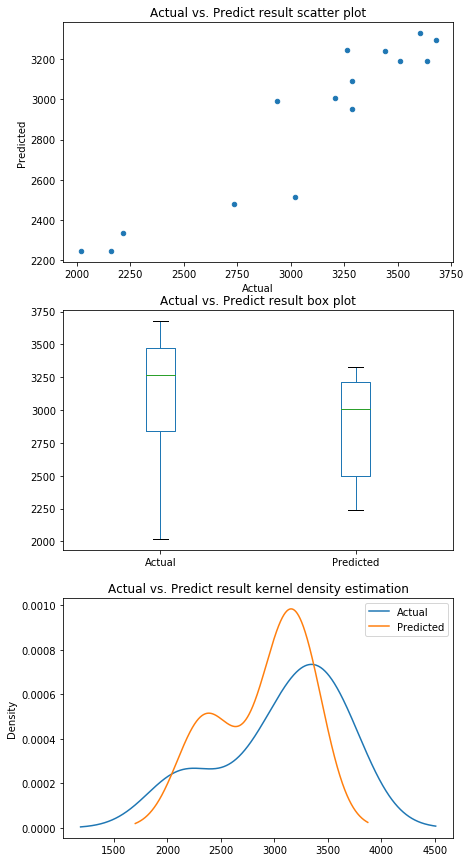

In [70]:
visualize_graph(df_pred_ANN_r)

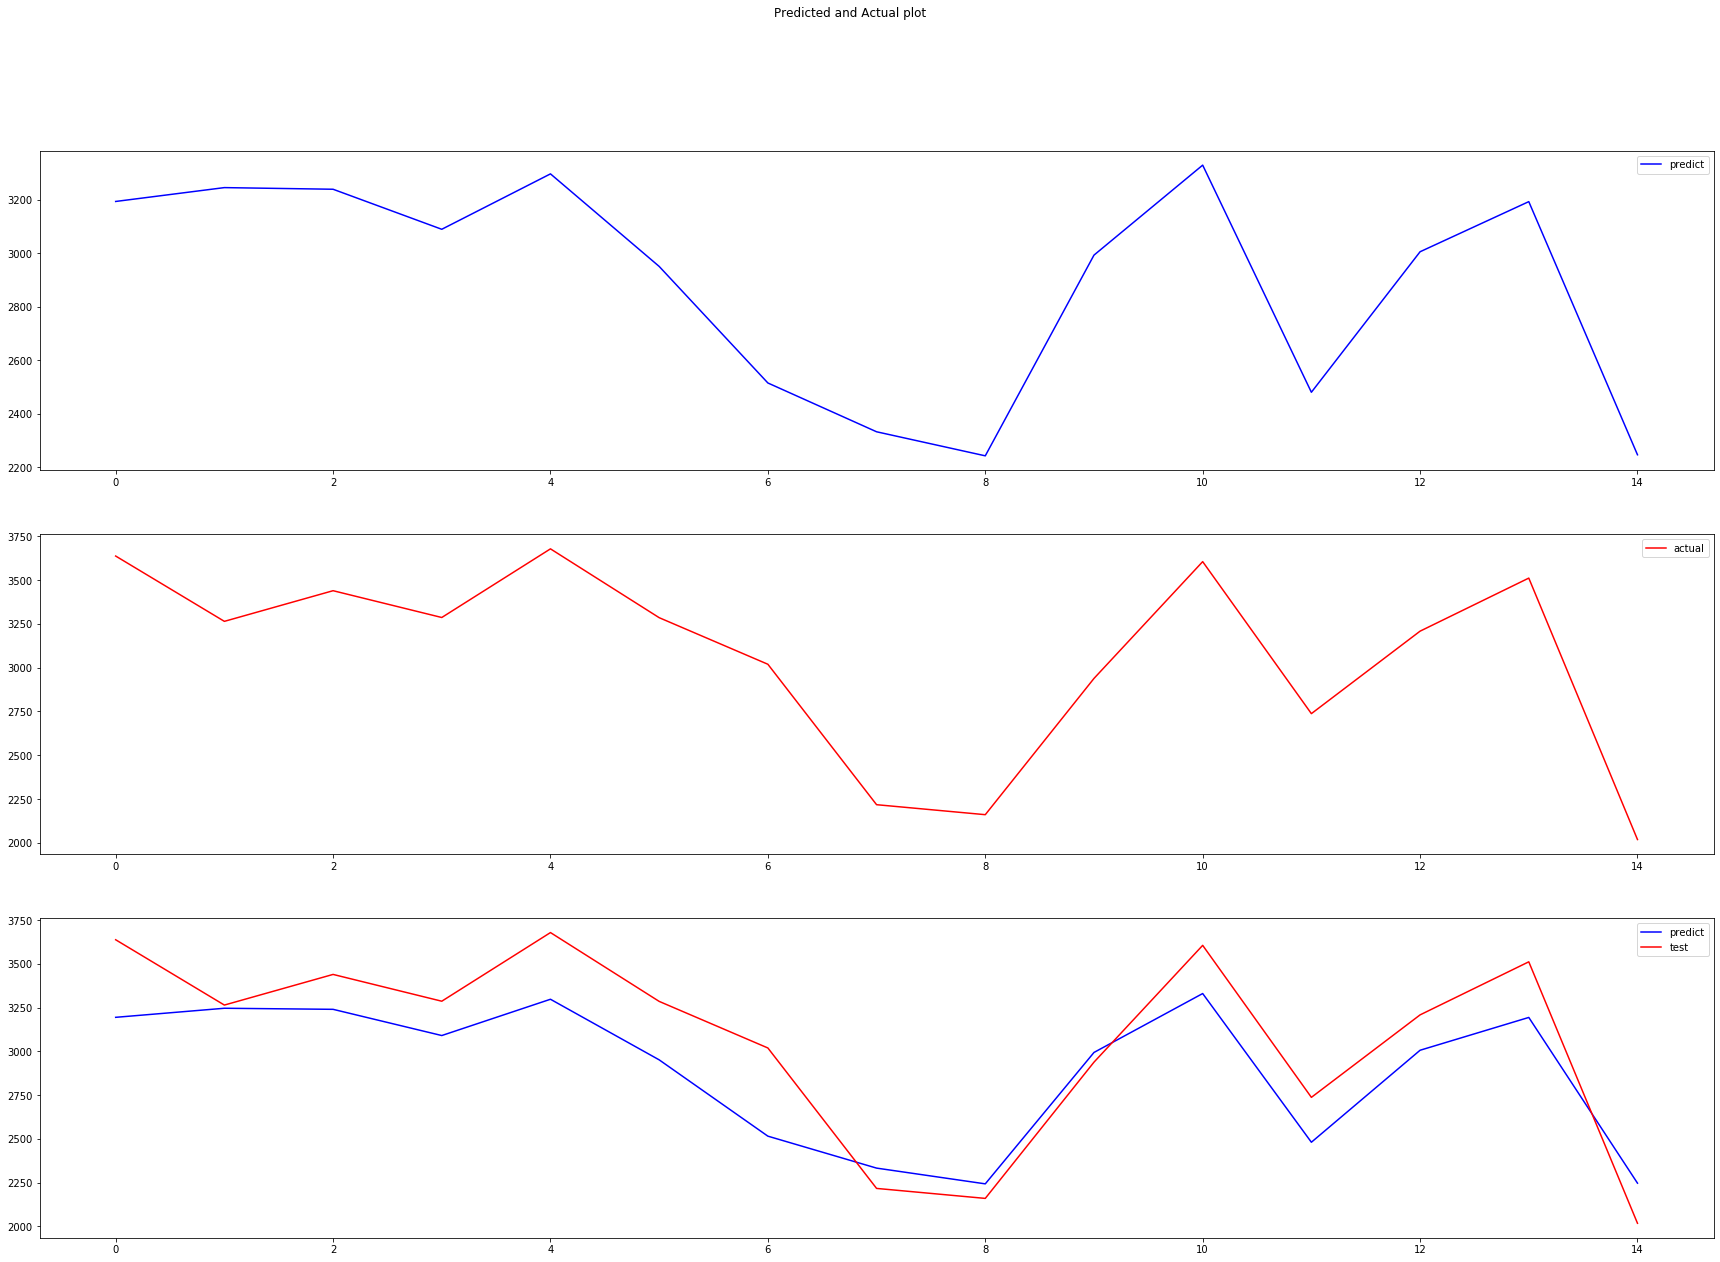

In [71]:
visualization(df_pred_ANN_r.Actual, df_pred_ANN_r.Predicted)